# Data Preprocessing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error, r2_score
import pandas as pd
import numpy as np
from scipy import stats

def pre_process():
    data = pd.read_csv('train.csv')
    stores = pd.read_csv('stores.csv')
    features = pd.read_csv('features.csv')

    features['CPI'] = features['CPI'].fillna(features['CPI'].median())
    features['Unemployment'] = features['Unemployment'].fillna(features['Unemployment'].median())
    for i in range(1, 6):
        features[f'MarkDown{i}'] = features[f'MarkDown{i}'].apply(lambda x: 0 if x < 0 else x).fillna(0)

    data = pd.merge(data, stores, on='Store', how='left')
    data = pd.merge(data, features, on=['Store', 'Date'], how='left')

    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data.sort_values(by='Date', inplace=True)
    data.set_index('Date', inplace=True)

    data.drop(columns='IsHoliday_x', inplace=True)
    data.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)

    agg = data.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()
    data = pd.merge(data.reset_index(), agg, on=['Store', 'Dept'], how='left')

    data['Total_MarkDown'] = sum([data[f'MarkDown{i}'] for i in range(1, 6)])
    data.drop([f'MarkDown{i}' for i in range(1, 6)], axis=1, inplace=True)

    numeric_col = ['Weekly_Sales', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Total_MarkDown']
    data_numeric = data[numeric_col].copy()
    data = data[(np.abs(stats.zscore(data_numeric)) < 2.5).all(axis=1)]
    # data = data[data['Weekly_Sales'] >= 0]
    data = data[data['Weekly_Sales'] >= 1]
    data['IsHoliday'] = data['IsHoliday'].astype(int)

    cat_col = ['Store', 'Dept', 'Type']
    for col in cat_col:
        data[col] = pd.factorize(data[col])[0]

    return data

# Feature Engineering

In [ ]:
# === Feature Engineering ===
def create_features(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    df['Lag_1_Week_Sales'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
    df['Lag_2_Week_Sales'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
    df['Rolling_Mean_2_Weeks'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=2).mean())
    df['Rolling_Mean_4_Weeks'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(window=4).mean())

    df['Store_Size_Interaction'] = df['Size'] * df['Weekly_Sales']
    df['Size_x_Fuel'] = df['Size'] * df['Fuel_Price']
    df['CPI_x_Unemp'] = df['CPI'] * df['Unemployment']
    df['Fuel_Price_sq'] = df['Fuel_Price']**2

    df.dropna(inplace=True)
    return df

# Get Data

In [ ]:
from IPython.display import display

def get_data_by_date_split(lstm_cols, mlp_cols):
    data = pre_process()
    data = create_features(data)

    print(">>>>>>>>>>>>>>>>>>>>>> data describe....")
    display(data.info())
    display(data.describe())

    # 🗓️ Split by actual date
    train_data = data[(data['Date'] >= '2010-02-05') & (data['Date'] <= '2012-03-30')].copy()
    val_data = data[(data['Date'] >= '2012-04-06') & (data['Date'] <= '2012-07-13')].copy()
    test_data = data[(data['Date'] >= '2012-07-20') & (data['Date'] <= '2012-10-26')].copy()

    def prepare_split(df):
        X = df.drop(['Weekly_Sales', 'Date'], axis=1)
        print(">>>>>>>>>>>>>>>>>>>>>> X data")
        print(X.head(5))

        # y = np.log1p(df['Weekly_Sales']) # this is impacted to the result, remember to change y_train_all variable as well
        y = df['Weekly_Sales']
        # print(">>>>>>>>>>>>>>>>>>>>>> np.log1p(data['Weekly_Sales'])")
        print(y.head(5))

        X_lstm = lstm_scaler.transform(X[lstm_cols])
        X_mlp = mlp_scaler.transform(X[mlp_cols])
        y_scaled = target_scaler.transform(y.values.reshape(-1, 1))
        return X_lstm, X_mlp, y_scaled

    print("Fitting scalers on training data...")
    # Fit scalers only on training data
    lstm_scaler = MinMaxScaler()
    mlp_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    X_train_all = train_data.drop(['Weekly_Sales', 'Date'], axis=1)
    y_train_all = np.log1p(train_data['Weekly_Sales'])
    # y_train_all = train_data['Weekly_Sales']

    lstm_scaler.fit(X_train_all[lstm_cols])
    mlp_scaler.fit(X_train_all[mlp_cols])
    target_scaler.fit(y_train_all.values.reshape(-1, 1))

    # Transform all splits
    X_lstm_train, X_mlp_train, y_train = prepare_split(train_data)
    X_lstm_val, X_mlp_val, y_val = prepare_split(val_data)
    X_lstm_test, X_mlp_test, y_test = prepare_split(test_data)

    return (
        X_lstm_train, X_mlp_train, y_train,
        X_lstm_val, X_mlp_val, y_val,
        X_lstm_test, X_mlp_test, y_test,
        target_scaler, val_data, test_data
    )

# Main Execution

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

LR_VALUE = 0.001

# === Main Execution ===
if __name__ == "__main__":
    # lstm_cols = [
    #     'IsHoliday', 'Year', 'Month', 'Week', 'DayOfWeek',
    #     'Lag_1_Week_Sales', 'Lag_2_Week_Sales', 'Rolling_Mean_2_Weeks', 'Rolling_Mean_4_Weeks',
    # ]
    lstm_cols = [
        'IsHoliday', 'Year', 'Month', 'Week', 'DayOfWeek',
        'Lag_1_Week_Sales', 'Lag_2_Week_Sales', 'Rolling_Mean_2_Weeks', 'Rolling_Mean_4_Weeks',
        'Total_MarkDown', 'min', 'max', 'mean', 'median', 'std', # this line is for trying remove if it's not getting better
    ]
    mlp_cols = [
        'Store', 'Dept', 'Type', 'Size',
        'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        # 'min', 'max', 'mean', 'median', 'std',
        'Total_MarkDown', 'Store_Size_Interaction',
        'Size_x_Fuel', 'CPI_x_Unemp', 'Fuel_Price_sq'
    ]

    # # testing to combine all columns and proceed to both process
    # combined_cols = list(set(lstm_cols + mlp_cols))
    # lstm_cols = combined_cols
    # mlp_cols = combined_cols
    # ####

    X_lstm_train, X_mlp_train, y_train, X_lstm_val, X_mlp_val, y_val, X_lstm_test, X_mlp_test, y_test, target_scaler, val_df, test_df = get_data_by_date_split(lstm_cols, mlp_cols)

>>>>>>>>>>>>>>>>>>>>>> data describe....
<class 'pandas.core.frame.DataFrame'>
Index: 363907 entries, 8888 to 421569
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    363907 non-null  datetime64[ns]
 1   Store                   363907 non-null  int64         
 2   Dept                    363907 non-null  int64         
 3   Weekly_Sales            363907 non-null  float64       
 4   Type                    363907 non-null  int64         
 5   Size                    363907 non-null  int64         
 6   Temperature             363907 non-null  float64       
 7   Fuel_Price              363907 non-null  float64       
 8   CPI                     363907 non-null  float64       
 9   Unemployment            363907 non-null  float64       
 10  IsHoliday               363907 non-null  int64         
 11  max                     363907 non-null  float64    

None

Date          Store           Dept  \
count                         363907  363907.000000  363907.000000   
mean   2011-06-28 23:58:39.276078336      20.891376      35.190931   
min              2010-02-26 00:00:00       0.000000       0.000000   
25%              2010-10-22 00:00:00      10.000000      17.000000   
50%              2011-06-24 00:00:00      21.000000      35.000000   
75%              2012-03-16 00:00:00      32.000000      53.000000   
max              2012-10-26 00:00:00      44.000000      79.000000   
std                              NaN      12.449016      21.252333   

        Weekly_Sales           Type           Size    Temperature  \
count  363907.000000  363907.000000  363907.000000  363907.000000   
mean    13088.450936       0.595526  134667.362604      60.834306   
min         1.000000       0.000000   34875.000000      14.020000   
25%      2027.220000       0.000000   93188.000000      48.200000   
50%      7150.510000       0.000000  128107.000000      63.080000   
75%     18300.025000       1.000000  202307.000000      74.480000   
max     72756.180000       2.000000  219622.000000     100.140000   
std     15386.791382       0.661660   60776.903021      17.817464   

          Fuel_Price            CPI   Unemployment  ...       Week  DayOfWeek  \
count  363907.000000  363907.000000  363907.000000  ...   363907.0   363907.0   
mean        3.369340     173.557593       7.676331  ...  26.272581        4.0   
min         2.513000     126.064000       3.879000  ...        1.0        4.0   
25%         2.921000     132.767067       6.855000  ...       15.0        4.0   
50%         3.480000     189.326096       7.808000  ...       26.0        4.0   
75%         3.743000     213.430299       8.494000  ...       38.0        4.0   
max         4.468000     227.232807      12.187000  ...       52.0        4.0   
std         0.460228      38.931092       1.384153  ...  13.657048        0.0   

       Lag_1_Week_Sales  Lag_2_Week_Sales  Rolling_Mean_2_Weeks  \
count     363907.000000     363907.000000         363907.000000   
mean       13091.282271      13095.962646          13089.866604   
min            1.000000          1.000000              1.000000   
25%         2028.055000       2028.620000           2062.102500   
50%         7154.670000       7159.790000           7200.925000   
75%        18299.520000      18306.500000          18360.327500   
max        72756.180000      72756.180000          72694.150000   
std        15387.968995      15390.737500          15283.292788   

       Rolling_Mean_4_Weeks  Store_Size_Interaction    Size_x_Fuel  \
count         363907.000000            3.639070e+05  363907.000000   
mean           13093.931482            1.972991e+09  453741.169376   
min                1.067500            3.487500e+04   89314.875000   
25%             2096.875000            2.130732e+08  293076.260000   
50%             7261.047500            8.673619e+08  463402.932000   
75%            18413.095000            2.585127e+09  607786.250000   
max            72429.200000            1.597313e+10  921757.336000   
std            15188.385300            2.694523e+09  214616.116725   

         CPI_x_Unemp  Fuel_Price_sq  
count  363907.000000  363907.000000  
mean     1321.710012      11.564262  
min       508.442511       6.315169  
25%      1096.092941       8.532241  
50%      1342.198992      12.110400  
75%      1594.433164      14.010049  
max      2218.390076      19.963024  
std       327.046180       3.081147  

[8 rows x 29 columns]

Fitting scalers on training data...
>>>>>>>>>>>>>>>>>>>>>> X data
      Store  Dept  Type    Size  Temperature  Fuel_Price         CPI  \
8888     31    67     1  120653        35.42       2.753  131.686000   
8890      9     5     1  128107        29.16       2.754  204.463087   
8893      9    57     1  128107        29.16       2.754  204.463087   
8894     32    59     1  119557        35.98       2.753  135.519519   
8895      7    41     0  203819        33.98       2.910  131.686000   

      Unemployment  IsHoliday       max  ...  Week  DayOfWeek  \
8888         9.202          0  32480.75  ...     8          4   
8890         8.187          0  15792.18  ...     8          4   
8893         8.187          0  59463.39  ...     8          4   
8894         8.283          0  14943.42  ...     8          4   
8895         8.326          0   9245.69  ...     8          4   

      Lag_1_Week_Sales  Lag_2_Week_Sales  Rolling_Mean_2_Weeks  \
8888          15733.07          15816.70    

# Phase 1: Train Validate Phase

In [ ]:
# === Custom Dataset ===
class CustomDataset(Dataset):
    def __init__(self, lstm_data, mlp_data, targets):
        self.lstm_data = lstm_data
        self.mlp_data = mlp_data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (torch.tensor(self.lstm_data[idx], dtype=torch.float32),
                torch.tensor(self.mlp_data[idx], dtype=torch.float32),
                torch.tensor(self.targets[idx], dtype=torch.float32))

# === Model Definition ===
class LSTMMLP(nn.Module):
    def __init__(self, lstm_input_size, mlp_input_size):
        super(LSTMMLP, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=64, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 + 16, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, lstm_input, mlp_input):
        lstm_input = lstm_input.unsqueeze(1)
        lstm_out, _ = self.lstm(lstm_input)
        lstm_feat = lstm_out[:, -1, :]
        mlp_feat = self.mlp(mlp_input)
        combined = torch.cat((lstm_feat, mlp_feat), dim=1)
        return self.fc(combined)

In [ ]:
def safe_mape(y_true, y_pred):
    mask = y_true > 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 # is this calculation correct? what if we remove np.abs method?

In [ ]:
def phase1_train_validate_by_date(X_lstm_train, X_mlp_train, y_train, X_lstm_val_full, X_mlp_val_full, y_val_full, lstm_cols, mlp_cols, val_data):
    print("\n🔁 Phase 1: Validation Walk (based on real date ranges)...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMMLP(len(lstm_cols), len(mlp_cols)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_VALUE) # what if we use other optimizers?
    criterion = nn.MSELoss()

    full_train_X_lstm, full_train_X_mlp, full_train_y = [], [], []

    unique_weeks = sorted(val_data['Date'].dt.isocalendar().week.unique())
    for i, week in enumerate(unique_weeks):
        mask = val_data['Date'].dt.isocalendar().week == week
        X_lstm_val = X_lstm_val_full[mask.values]
        X_mlp_val = X_mlp_val_full[mask.values]
        y_val = y_val_full[mask.values]

        print(f"▶ Iteration {i+1}: Validating on Week {week}, Samples = {len(y_val)}")
        # print(val_data.loc[mask, ['Store', 'Dept', 'Date', 'Weekly_Sales']].head()) # trying this line to give more info about the data processed
        print(val_data.loc[mask].head())

        train_dataset = CustomDataset(X_lstm_train, X_mlp_train, y_train)
        val_dataset = CustomDataset(X_lstm_val, X_mlp_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # what if we use different batch size?
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        model.train()
        for lstm_x, mlp_x, y in train_loader:
            lstm_x, mlp_x, y = lstm_x.to(device), mlp_x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(lstm_x, mlp_x)
            loss = criterion(output.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for lstm_x, mlp_x, y in val_loader:
                lstm_x, mlp_x, y = lstm_x.to(device), mlp_x.to(device), y.to(device)
                output = model(lstm_x, mlp_x)
                val_loss = criterion(output.squeeze(), y.squeeze())
                val_losses.append(val_loss.item())

        print(f"  [Val Loss] {np.mean(val_losses):.6f}")

        # Update training set (these 3 variables below are not being used anywhere? can delete?)
        X_lstm_train = np.vstack([X_lstm_train, X_lstm_val])
        X_mlp_train = np.vstack([X_mlp_train, X_mlp_val])
        y_train = np.vstack([y_train, y_val])

        full_train_X_lstm.append(X_lstm_val)
        full_train_X_mlp.append(X_mlp_val)
        full_train_y.append(y_val)

    print("✅ Phase 1 complete. Model ready for Phase 2.")
    return model, np.vstack(full_train_X_lstm), np.vstack(full_train_X_mlp), np.vstack(full_train_y)

## Execute Phase 1

In [ ]:
print("🔁 Phase 1: Validation Walk...")
model, _, _, _ = phase1_train_validate_by_date(
    X_lstm_train, X_mlp_train, y_train,
    X_lstm_val, X_mlp_val, y_val,
    lstm_cols, mlp_cols, val_df
)

🔁 Phase 1: Validation Walk...

🔁 Phase 1: Validation Walk (based on real date ranges)...
▶ Iteration 1: Validating on Week 14, Samples = 2834
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
332778 2012-04-06     39    60      19572.19     2   41062        64.70   
332779 2012-04-06     13    39       6177.65     2   39910        73.95   
332780 2012-04-06     12    62      12493.09     0  155083        36.54   
332781 2012-04-06     12    41       3530.03     0  155083        36.54   
332782 2012-04-06     14    47        490.63     0  196321        48.48   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
332778       3.891  212.888754         9.575  ...    14          4   
332779       3.891  220.120412         6.989  ...    14          4   
332780       3.957  137.797097         4.125  ...    14          4   
332781       3.957  137.797097         4.125  ...    14          4   
332782       3.854  197.597128         6.547  ...    14  

# Visualization Functions

In [ ]:
def plot_actual_vs_predicted(actuals, preds, title="Actual vs Predicted Sales"):
    plt.figure(figsize=(14, 5))
    plt.plot(actuals, label='Actual', alpha=0.7)
    plt.plot(preds, label='Predicted', alpha=0.7)
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_largest_errors(actuals, preds, top_n=100):
    actuals = np.array(actuals)
    preds = np.array(preds)
    errors = np.abs(actuals - preds)
    sorted_idx = np.argsort(-errors)[:top_n]

    plt.figure(figsize=(14, 5))
    plt.plot(actuals[sorted_idx], label='Actual')
    plt.plot(preds[sorted_idx], label='Predicted')
    plt.title(f"Top {top_n} Largest Prediction Errors")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_error_distribution(actuals, preds):
    errors = abs(actuals - preds)
    plt.figure(figsize=(10, 4))
    plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
    plt.title("Distribution of Prediction Errors")
    plt.xlabel("Error (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def scatter_actual_vs_predicted(actuals, preds):
    plt.figure(figsize=(6, 6))
    plt.scatter(actuals, preds, alpha=0.4, edgecolors='k')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--')
    plt.title("Scatter: Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Phase 2: Train Test Phase

In [ ]:
def phase2_train_test_by_date(model, X_lstm_train, X_mlp_train, y_train,
                               X_lstm_test, X_mlp_test, y_test,
                               target_scaler, test_data):
    print("\n🧠 Phase 2: Testing Walk (based on real date ranges)...")
    test_data = test_data.copy()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_metrics = []
    all_preds, all_actuals = [], []

    unique_weeks = sorted(test_data['Date'].dt.isocalendar().week.unique())
    for i, week in enumerate(unique_weeks):
        mask = test_data['Date'].dt.isocalendar().week == week
        X_lstm_batch = X_lstm_test[mask.values]
        X_mlp_batch = X_mlp_test[mask.values]
        y_batch = y_test[mask.values]

        print(f"▶ Iteration {i+1}: Testing on Week {week}, Samples = {len(y_batch)}")
        print(test_data.loc[mask, ['Store', 'Dept', 'Date', 'Weekly_Sales']].head()) # trying this line

        # Train
        train_dataset = CustomDataset(X_lstm_train, X_mlp_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # figure out if batch size is impacting the performance?
        model.to(device)
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR_VALUE)
        criterion = nn.MSELoss()

        for lstm_x, mlp_x, y in train_loader:
            lstm_x, mlp_x, y = lstm_x.to(device), mlp_x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(lstm_x, mlp_x)
            loss = criterion(output.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()

        # Predict
        test_dataset = CustomDataset(X_lstm_batch, X_mlp_batch, y_batch)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        model.eval()
        preds, actuals = [], []
        with torch.no_grad():
            for lstm_x, mlp_x, y in test_loader:
                lstm_x, mlp_x, y = lstm_x.to(device), mlp_x.to(device), y.to(device)
                output = model(lstm_x, mlp_x)
                preds.extend(output.cpu().numpy())
                actuals.extend(y.cpu().numpy())

        # preds = np.expm1(preds)
        # actuals = np.expm1(actuals)

        mse = mean_squared_error(actuals, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, preds)
        mape = safe_mape(np.array(actuals), np.array(preds))
        # mape = mean_absolute_percentage_error(actuals, preds)
        r2 = r2_score(actuals, preds)

        print(f"  MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}%, R2={r2:.4f}")

        all_preds.extend(preds)
        all_actuals.extend(actuals)
        all_metrics.append([mse, rmse, mae, mape, r2])

        # Update training set with this test week (these 3 varaibles are useless? can remove?)
        X_lstm_train = np.vstack([X_lstm_train, X_lstm_batch])
        X_mlp_train = np.vstack([X_mlp_train, X_mlp_batch])
        y_train = np.vstack([y_train, y_batch])

    return np.array(all_metrics), np.array(all_actuals), np.array(all_preds)

# === Evaluate ===
def evaluate(all_metrics):
    metric_names = ["MSE", "RMSE", "MAE", "MAPE", "R²"]
    means = np.mean(all_metrics, axis=0)
    # stds = np.std(all_metrics, axis=0)
    stderrs = np.std(all_metrics, axis=0, ddof=0) / np.sqrt(all_metrics.shape[0])

    print("\n📊 Final Evaluation:")
    for name, mean, stderr in zip(metric_names, means, stderrs):
        # print(f"{name}: {mean:.2f} ± {stderr:.4f}")
        print(f"{name}: {mean:.4f} ± {stderr:.6f}")

## Execute Phase 2

In [ ]:
print("🧠 Phase 2: Testing Walk...")
all_metrics, all_actuals, all_preds = phase2_train_test_by_date(
    model,
    np.vstack([X_lstm_train, X_lstm_val]),
    np.vstack([X_mlp_train, X_mlp_val]),
    np.vstack([y_train, y_val]),
    X_lstm_test, X_mlp_test, y_test,
    target_scaler, test_df
)

evaluate(all_metrics)

🧠 Phase 2: Testing Walk...

🧠 Phase 2: Testing Walk (based on real date ranges)...
▶ Iteration 1: Testing on Week 29, Samples = 2697
        Store  Dept       Date  Weekly_Sales
377155     31    57 2012-07-20      63473.49
377156     41    14 2012-07-20       3715.00
377157     12    42 2012-07-20       1731.83
377158     24    53 2012-07-20       7360.64
377159      4     4 2012-07-20      26049.42
  MSE=22.9969, RMSE=4.7955, MAE=3.0709, MAPE=21.2936%, R2=1.0000
▶ Iteration 2: Testing on Week 30, Samples = 2827
        Store  Dept       Date  Weekly_Sales
380107     42     1 2012-07-27        149.84
380108     36    16 2012-07-27       4903.34
380109     16    26 2012-07-27       4983.72
380110     12    46 2012-07-27        779.98
380111     44     0 2012-07-27      11633.87
  MSE=13.0787, RMSE=3.6164, MAE=2.1525, MAPE=3.7463%, R2=1.0000
▶ Iteration 3: Testing on Week 31, Samples = 1659
        Store  Dept       Date  Weekly_Sales
383041     12     9 2012-08-03       5929.29
383048  

# Result visualizations

In [ ]:
all_actuals = all_actuals.flatten()
all_preds = all_preds.flatten()

## Actual vs Prediction

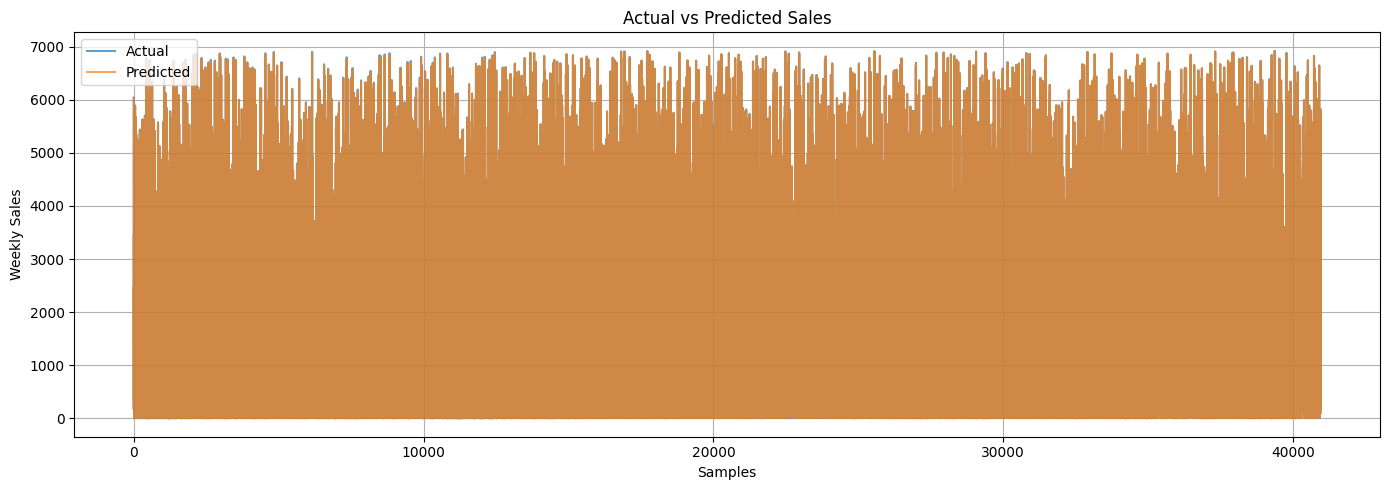

In [ ]:
plot_actual_vs_predicted(all_actuals, all_preds)

## Largest Error Plot

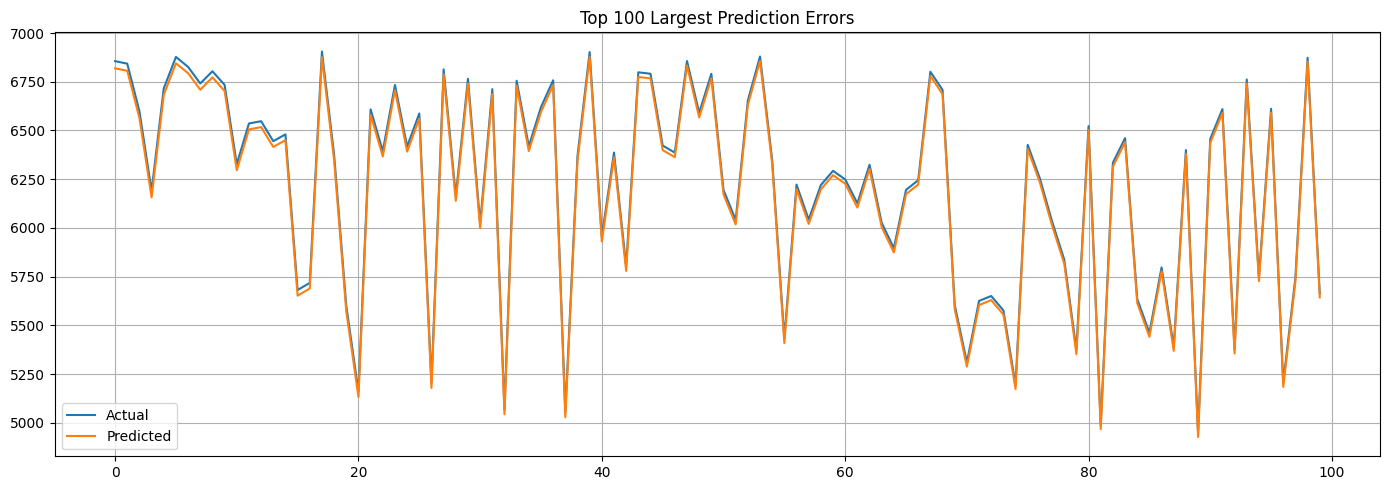

In [ ]:
plot_largest_errors(all_actuals, all_preds)

## Plot error distribution

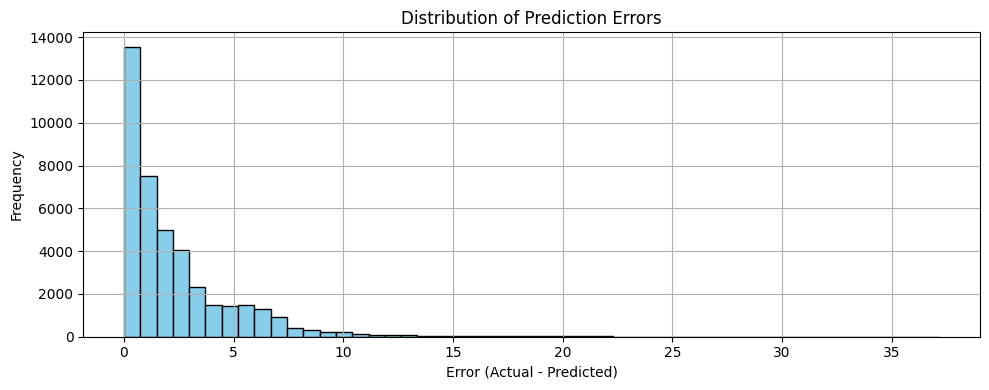

In [ ]:
plot_error_distribution(all_actuals, all_preds)

## Scatter actual vs predicted

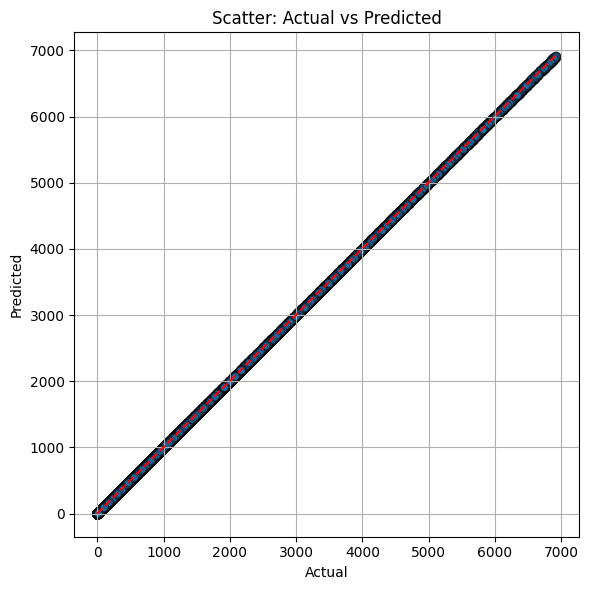

In [ ]:
scatter_actual_vs_predicted(all_actuals, all_preds)

In [ ]:
def plot_best_predictions(actuals, preds, top_n=100):
    actuals = np.array(actuals).flatten()
    preds = np.array(preds).flatten()
    errors = np.abs(actuals - preds)
    sorted_idx = np.argsort(errors)[:top_n]

    plt.figure(figsize=(14, 5))
    plt.plot(actuals[sorted_idx], label='Actual')
    plt.plot(preds[sorted_idx], label='Predicted')
    plt.title(f"Top {top_n} Closest Predictions")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_residuals(actuals, preds):
    actuals = np.array(actuals).flatten()
    preds = np.array(preds).flatten()
    residuals = abs(actuals - preds)

    plt.figure(figsize=(8, 5))
    plt.scatter(preds, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Residuals vs Predictions")
    plt.xlabel("Predicted Sales")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_error_by_bins(actuals, preds, bins=10):
    actuals = np.array(actuals).flatten()
    preds = np.array(preds).flatten()
    errors = np.abs(actuals - preds)

    bin_indices = np.digitize(actuals, np.linspace(min(actuals), max(actuals), bins))
    avg_error_per_bin = [errors[bin_indices == i].mean() for i in range(1, bins + 1)]

    plt.figure(figsize=(8, 5))
    plt.bar(range(1, bins + 1), avg_error_per_bin, color='skyblue', edgecolor='black')
    plt.title("Mean Absolute Error per Actual Sales Bin")
    plt.xlabel("Bin (by actual sales value range)")
    plt.ylabel("Mean Absolute Error")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def plot_cumulative_error(actuals, preds):
    actuals = np.array(actuals).flatten()
    preds = np.array(preds).flatten()
    errors = np.abs(actuals - preds)
    sorted_errors = np.sort(errors)[::-1]
    cumulative_error = np.cumsum(sorted_errors)
    total = cumulative_error[-1]
    x = np.arange(len(errors)) / len(errors)

    plt.figure(figsize=(10, 5))
    plt.plot(x, cumulative_error / total, label='Cumulative Error')
    plt.axhline(0.8, color='r', linestyle='--', label='80% Threshold')
    plt.title("Cumulative Error Contribution")
    plt.xlabel("Proportion of Samples")
    plt.ylabel("Cumulative Error %")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Plot best prediction

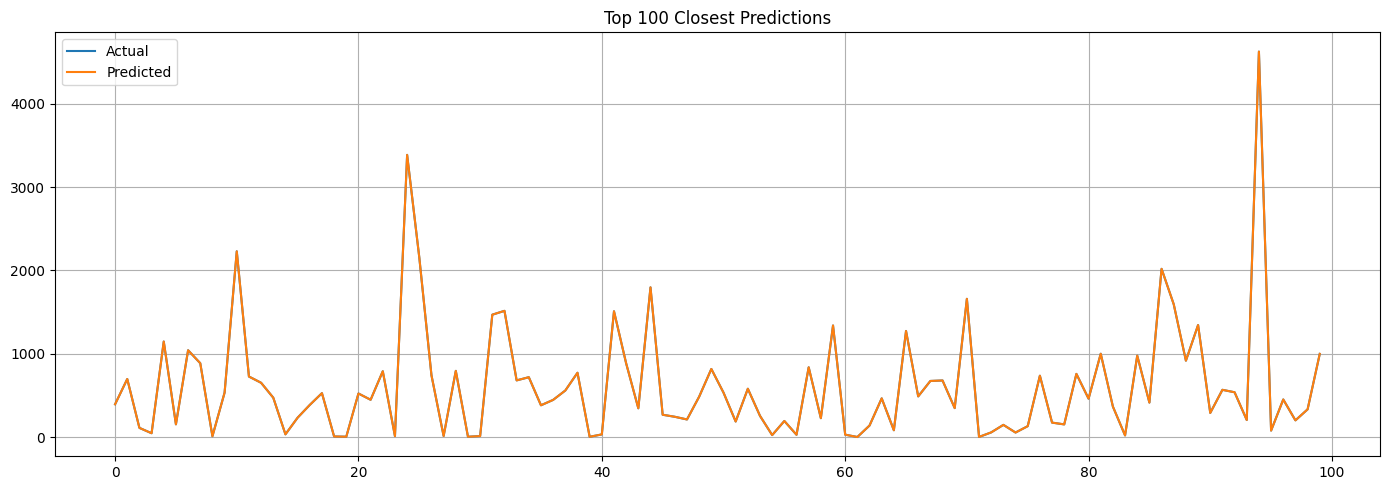

In [ ]:
plot_best_predictions(all_actuals, all_preds)

## Plot residuals

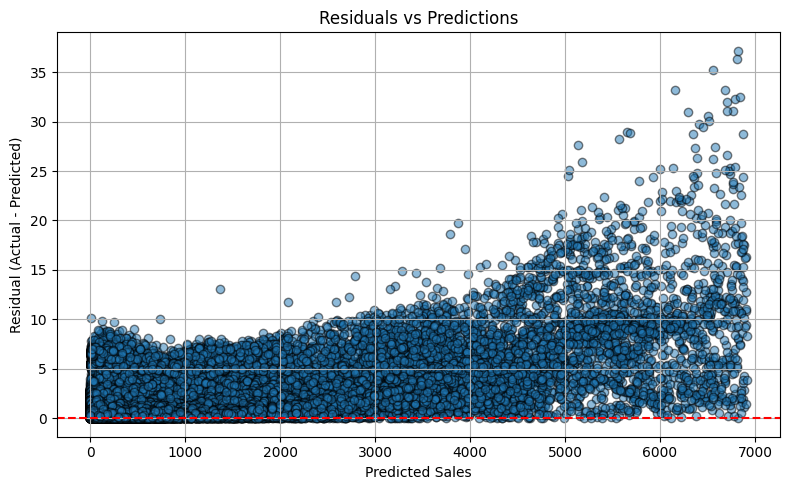

In [ ]:
plot_residuals(all_actuals, all_preds)

## Plot error by bins

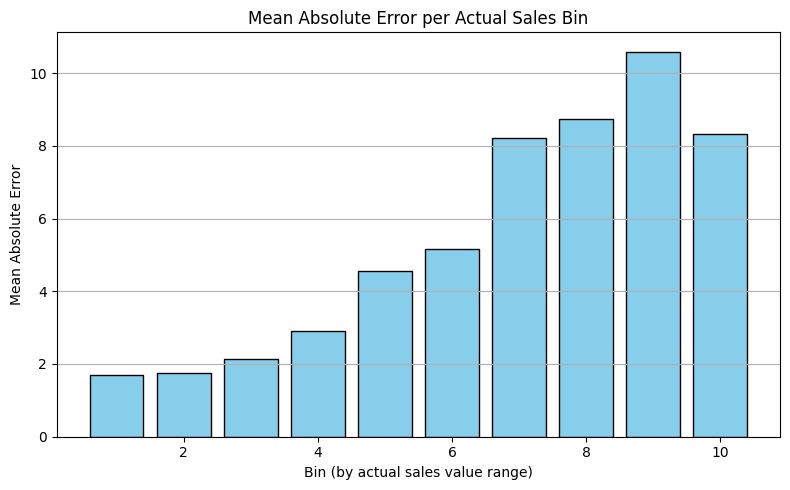

In [ ]:
plot_error_by_bins(all_actuals, all_preds)

## Plot cumulative error

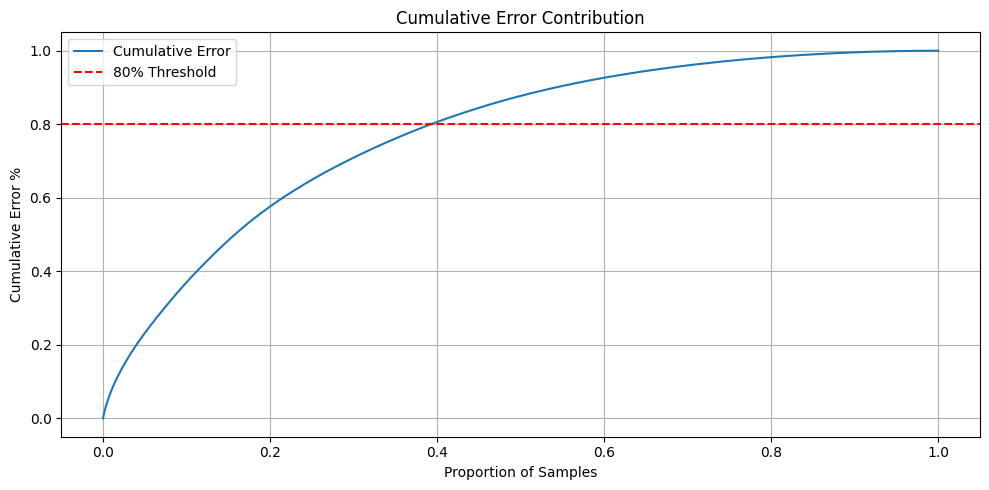

In [ ]:
plot_cumulative_error(all_actuals, all_preds)

In [ ]:
def plot_weekly_errors(metric_list, metric_name="MAE"):
    import matplotlib.pyplot as plt

    metric_idx = {"MSE": 0, "RMSE": 1, "MAE": 2, "MAPE": 3, "R²": 4}[metric_name.upper()]
    values = [week[metric_idx] for week in metric_list]

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(values)+1), values, marker='o')
    plt.title(f"Weekly {metric_name.upper()} Trend")
    plt.xlabel("Test Iteration (Week)")
    plt.ylabel(metric_name.upper())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_zoomed_comparison(actuals, preds, start_idx=0, length=100):
    actuals = np.array(actuals).flatten()
    preds = np.array(preds).flatten()

    plt.figure(figsize=(12, 4))
    plt.plot(actuals[start_idx:start_idx+length], label='Actual')
    plt.plot(preds[start_idx:start_idx+length], label='Predicted')
    plt.title(f"Zoomed Comparison (index {start_idx} to {start_idx+length})")
    plt.xlabel("Time Step")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confidence_band(actuals, preds, window=20):
    import matplotlib.pyplot as plt
    import numpy as np

    actuals = np.array(actuals).flatten()
    preds = np.array(preds).flatten()
    std = pd.Series(np.abs(actuals - preds)).rolling(window).std()

    plt.figure(figsize=(12, 4))
    plt.plot(preds, label='Predicted', color='blue')
    plt.fill_between(np.arange(len(preds)),
                     preds - 1.96*std,
                     preds + 1.96*std,
                     color='blue', alpha=0.2, label='~95% pseudo-CI')
    plt.plot(actuals, label='Actual', color='black', alpha=0.6)
    plt.title("Predictions with Confidence Band (approx.)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_sales_vs_error(actuals, preds):
    actuals = np.array(actuals).flatten()
    preds = np.array(preds).flatten()
    errors = np.abs(actuals - preds)

    plt.figure(figsize=(6, 5))
    plt.scatter(actuals, errors, alpha=0.4, edgecolor='k')
    plt.xlabel("Actual Sales")
    plt.ylabel("Absolute Error")
    plt.title("Error vs Actual Sales Level")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Plot Zoomed Comparison

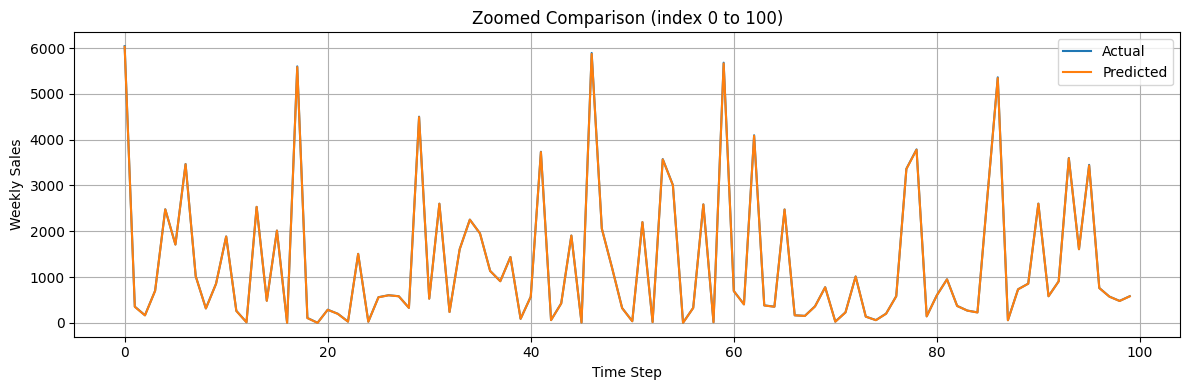

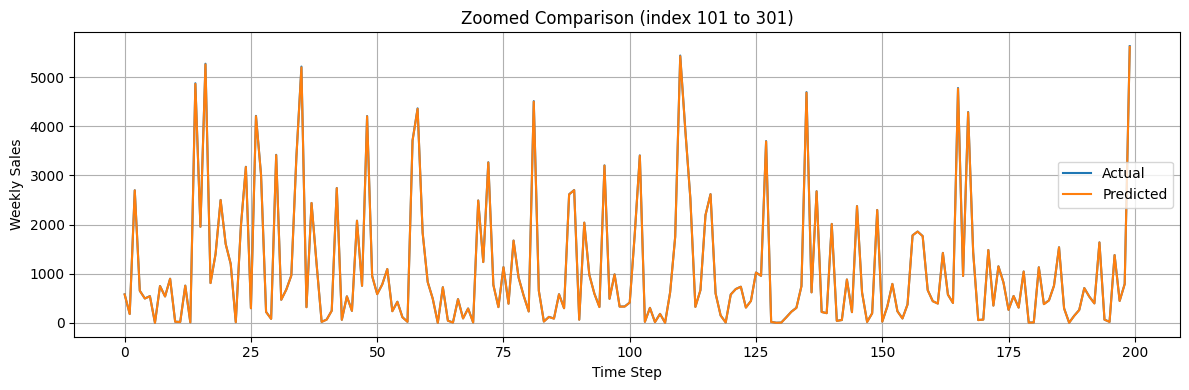

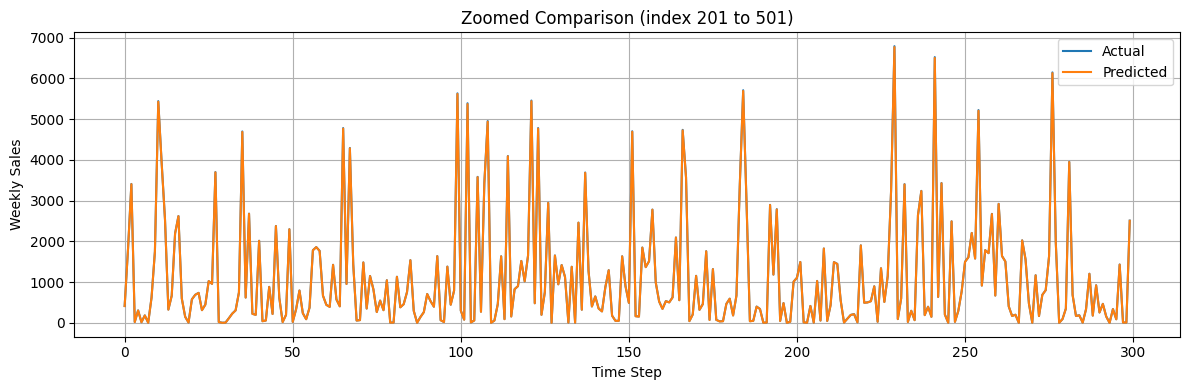

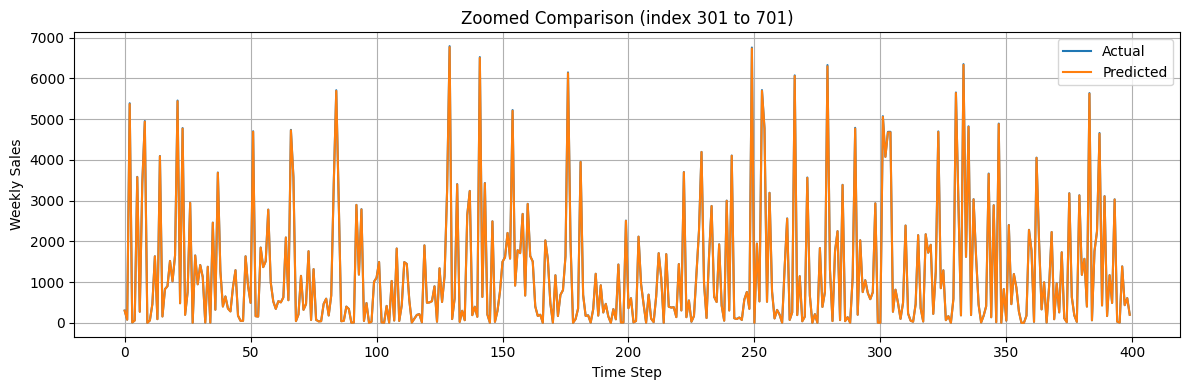

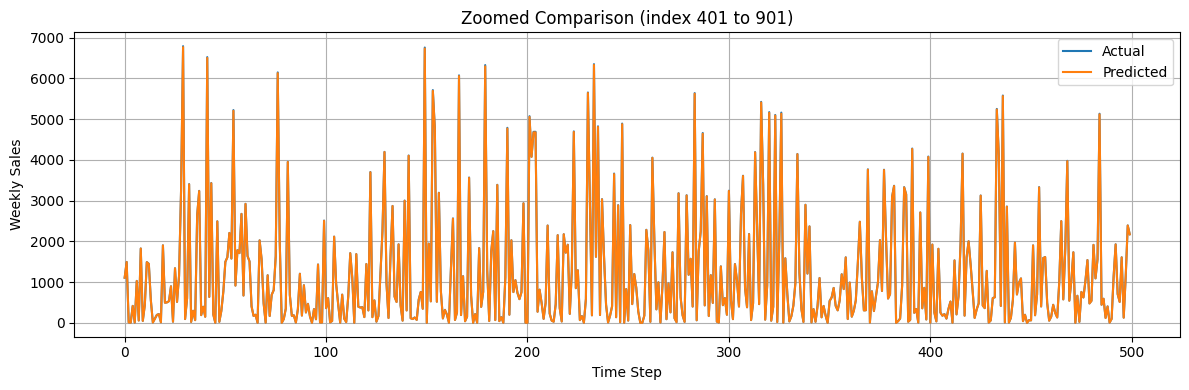

In [ ]:
plot_zoomed_comparison(all_actuals, all_preds, start_idx=0, length=100)
plot_zoomed_comparison(all_actuals, all_preds, start_idx=101, length=200)
plot_zoomed_comparison(all_actuals, all_preds, start_idx=201, length=300)
plot_zoomed_comparison(all_actuals, all_preds, start_idx=301, length=400)
plot_zoomed_comparison(all_actuals, all_preds, start_idx=401, length=500)

## Plot Confidence Band

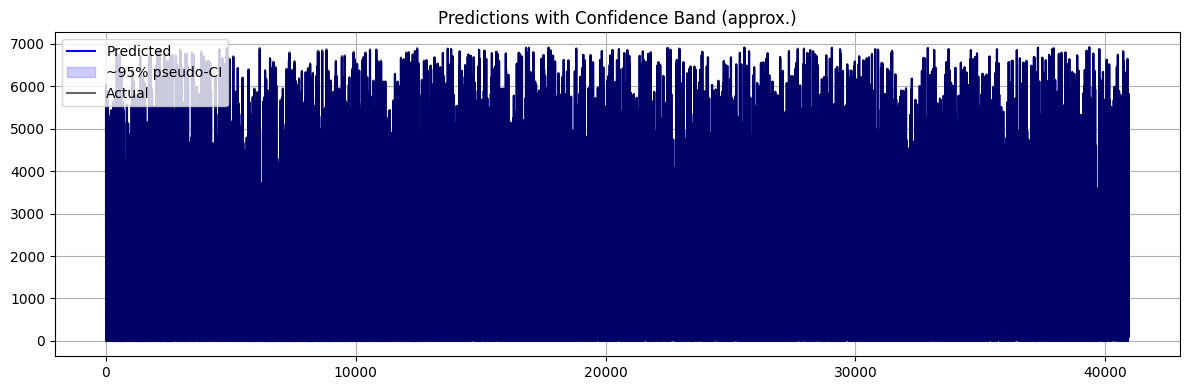

In [ ]:
plot_confidence_band(all_actuals, all_preds, window=20)

## Plot Sales vs Error

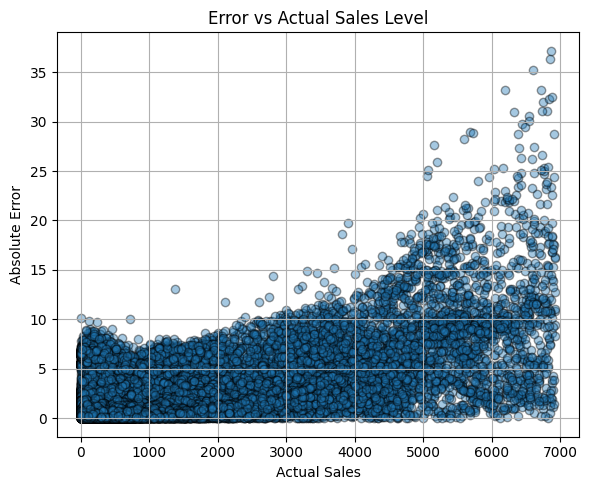

In [ ]:
plot_sales_vs_error(all_actuals, all_preds)

## Plot Weekly Error

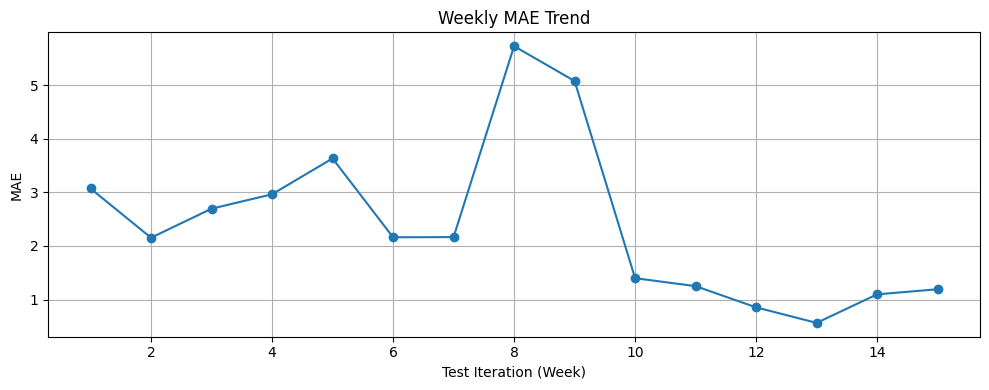

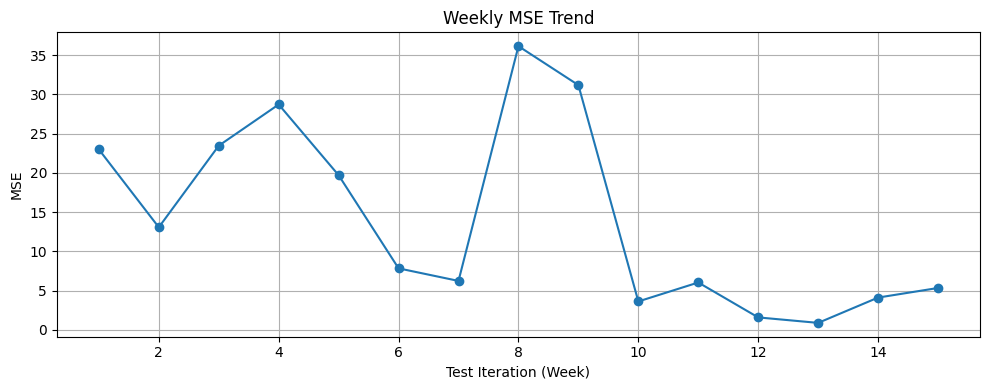

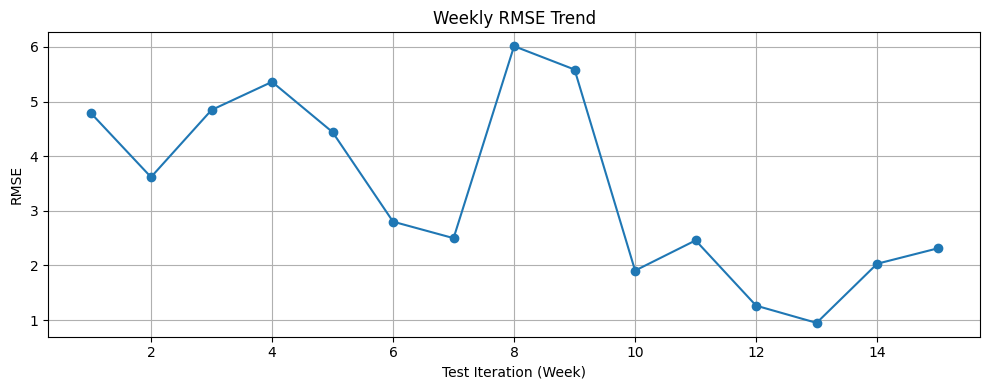

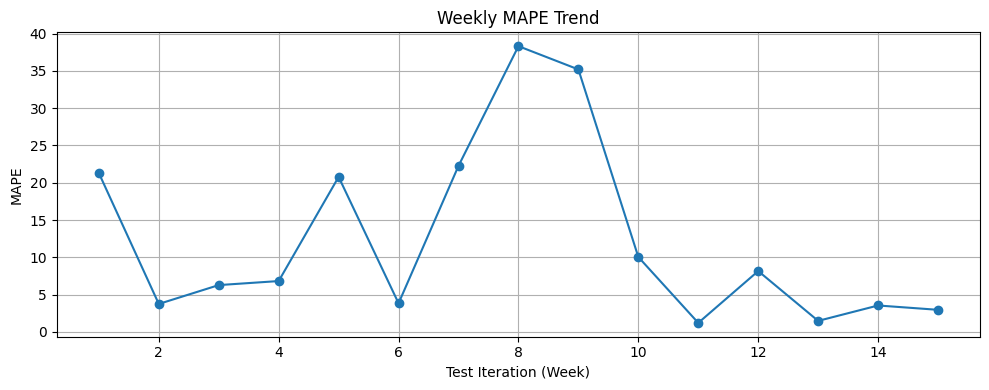

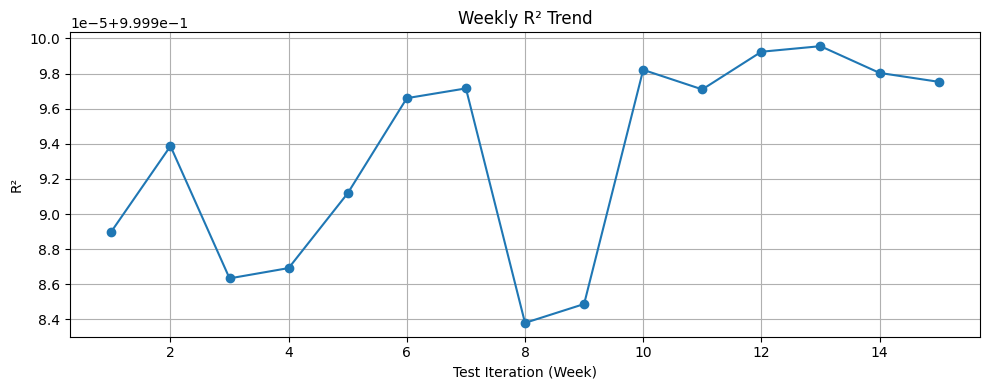

In [ ]:
plot_weekly_errors(all_metrics, metric_name="MAE")
plot_weekly_errors(all_metrics, metric_name="MSE")
plot_weekly_errors(all_metrics, metric_name="RMSE")
plot_weekly_errors(all_metrics, metric_name="MAPE")
plot_weekly_errors(all_metrics, metric_name="R²")

# Other methods comparison

## Phase 1 Codes

## CustomDataset

In [ ]:
class CustomDatasetSingle(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [ ]:
def phase1_train_validate_by_date_other_methods(model, X_train, y_train, X_val_full, y_val_full, cols, val_data):
    print("\n🔁 Phase 1: Validation Walk (based on real date ranges)...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_VALUE)
    criterion = nn.MSELoss()

    full_train_X, full_train_y = [], []

    unique_weeks = sorted(val_data['Date'].dt.isocalendar().week.unique())
    for i, week in enumerate(unique_weeks):
        mask = val_data['Date'].dt.isocalendar().week == week
        X_val = X_val_full[mask.values]
        y_val = y_val_full[mask.values]

        print(f"▶ Iteration {i+1}: Validating on Week {week}, Samples = {len(y_val)}")
        print(val_data.loc[mask].head())

        train_dataset = CustomDatasetSingle(X_train, y_train)
        val_dataset = CustomDatasetSingle(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                val_loss = criterion(output.squeeze(), y.squeeze())
                val_losses.append(val_loss.item())

        print(f"[Val Loss] {np.mean(val_losses):.6f}")

        full_train_X.append(X_val)
        full_train_y.append(y_val)

    print("✅ Phase 1 complete. Model ready for Phase 2.")
    return model, np.vstack(full_train_X), np.vstack(full_train_y)

## Phase 2 Codes

In [ ]:
def phase2_train_test_by_date_other_methods(
    model,
    X_train, y_train,
    X_test, y_test,
    target_scaler, test_data
):
    print("\n🧠 Phase 2: Testing Walk (based on real date ranges)...")
    test_data = test_data.copy()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_metrics = []
    all_preds, all_actuals = [], []

    unique_weeks = sorted(test_data['Date'].dt.isocalendar().week.unique())
    # print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    # print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> test_data ", X_test[:5])
    # print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> X_train ", X_train[:5])
    # print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> y_train ", y_train[:5])
    # print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> target_scaler ", target_scaler)
    # print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> test_data ", test_data.head())
    # print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<< unique weeks")
    for i, week in enumerate(unique_weeks):
        mask = test_data['Date'].dt.isocalendar().week == week
        # print(">>>>>>>>>>>>>>>>>>>>>>>>>> week ==> ", week)
        # print(">>>>>>>>>>>>>>>>>>>>>>>>>> mask values ==> ", mask.values)
        # print(">>>>>>>>>>>>>>>>>>>>>>>>>> mask ==> ", mask)
        X_batch = X_test[mask.values]
        y_batch = y_test[mask.values]

        print(f"▶ Iteration {i+1}: Testing on Week {week}, Samples = {len(y_batch)}")
        print(test_data.loc[mask].head())

        # Train
        train_dataset = CustomDatasetSingle(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
        model.to(device)
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR_VALUE)
        criterion = nn.MSELoss()

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(), y.squeeze())
            loss.backward()
            optimizer.step()

        # Predict
        test_dataset = CustomDatasetSingle(X_batch, y_batch)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        model.eval()
        preds, actuals = [], []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                preds.extend(output.cpu().numpy())
                actuals.extend(y.cpu().numpy())

        mse = mean_squared_error(actuals, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, preds)
        mape = safe_mape(np.array(actuals), np.array(preds))
        r2 = r2_score(actuals, preds)

        print(f"  MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}%, R2={r2:.4f}")

        all_preds.extend(preds)
        all_actuals.extend(actuals)
        all_metrics.append([mse, rmse, mae, mape, r2])

    return np.array(all_metrics), np.array(all_actuals), np.array(all_preds)

## MLP Only

In [ ]:
class MLPOnly(nn.Module):
    def __init__(self, input_size):
        super(MLPOnly, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
"""# Other methods comparison: Standalone training/val/test functions for single-architecture models"""
combined_cols = list(set(lstm_cols + mlp_cols))

# Re-extract the data using existing pre-processing
X_lstm_train, X_mlp_train, y_train, X_lstm_val, X_mlp_val, y_val, X_lstm_test, X_mlp_test, y_test, target_scaler, val_df, test_df = get_data_by_date_split(lstm_cols, mlp_cols)

# Combine the inputs into one tensor
X_train_all = np.concatenate([X_lstm_train, X_mlp_train], axis=1)
X_val_all = np.concatenate([X_lstm_val, X_mlp_val], axis=1)
X_test_all = np.concatenate([X_lstm_test, X_mlp_test], axis=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

>>>>>>>>>>>>>>>>>>>>>> data describe....
<class 'pandas.core.frame.DataFrame'>
Index: 363907 entries, 8888 to 421569
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    363907 non-null  datetime64[ns]
 1   Store                   363907 non-null  int64         
 2   Dept                    363907 non-null  int64         
 3   Weekly_Sales            363907 non-null  float64       
 4   Type                    363907 non-null  int64         
 5   Size                    363907 non-null  int64         
 6   Temperature             363907 non-null  float64       
 7   Fuel_Price              363907 non-null  float64       
 8   CPI                     363907 non-null  float64       
 9   Unemployment            363907 non-null  float64       
 10  IsHoliday               363907 non-null  int64         
 11  max                     363907 non-null  float64    

None

Date          Store           Dept  \
count                         363907  363907.000000  363907.000000   
mean   2011-06-28 23:58:39.276078336      20.891376      35.190931   
min              2010-02-26 00:00:00       0.000000       0.000000   
25%              2010-10-22 00:00:00      10.000000      17.000000   
50%              2011-06-24 00:00:00      21.000000      35.000000   
75%              2012-03-16 00:00:00      32.000000      53.000000   
max              2012-10-26 00:00:00      44.000000      79.000000   
std                              NaN      12.449016      21.252333   

        Weekly_Sales           Type           Size    Temperature  \
count  363907.000000  363907.000000  363907.000000  363907.000000   
mean    13088.450936       0.595526  134667.362604      60.834306   
min         1.000000       0.000000   34875.000000      14.020000   
25%      2027.220000       0.000000   93188.000000      48.200000   
50%      7150.510000       0.000000  128107.000000      63.080000   
75%     18300.025000       1.000000  202307.000000      74.480000   
max     72756.180000       2.000000  219622.000000     100.140000   
std     15386.791382       0.661660   60776.903021      17.817464   

          Fuel_Price            CPI   Unemployment  ...       Week  DayOfWeek  \
count  363907.000000  363907.000000  363907.000000  ...   363907.0   363907.0   
mean        3.369340     173.557593       7.676331  ...  26.272581        4.0   
min         2.513000     126.064000       3.879000  ...        1.0        4.0   
25%         2.921000     132.767067       6.855000  ...       15.0        4.0   
50%         3.480000     189.326096       7.808000  ...       26.0        4.0   
75%         3.743000     213.430299       8.494000  ...       38.0        4.0   
max         4.468000     227.232807      12.187000  ...       52.0        4.0   
std         0.460228      38.931092       1.384153  ...  13.657048        0.0   

       Lag_1_Week_Sales  Lag_2_Week_Sales  Rolling_Mean_2_Weeks  \
count     363907.000000     363907.000000         363907.000000   
mean       13091.282271      13095.962646          13089.866604   
min            1.000000          1.000000              1.000000   
25%         2028.055000       2028.620000           2062.102500   
50%         7154.670000       7159.790000           7200.925000   
75%        18299.520000      18306.500000          18360.327500   
max        72756.180000      72756.180000          72694.150000   
std        15387.968995      15390.737500          15283.292788   

       Rolling_Mean_4_Weeks  Store_Size_Interaction    Size_x_Fuel  \
count         363907.000000            3.639070e+05  363907.000000   
mean           13093.931482            1.972991e+09  453741.169376   
min                1.067500            3.487500e+04   89314.875000   
25%             2096.875000            2.130732e+08  293076.260000   
50%             7261.047500            8.673619e+08  463402.932000   
75%            18413.095000            2.585127e+09  607786.250000   
max            72429.200000            1.597313e+10  921757.336000   
std            15188.385300            2.694523e+09  214616.116725   

         CPI_x_Unemp  Fuel_Price_sq  
count  363907.000000  363907.000000  
mean     1321.710012      11.564262  
min       508.442511       6.315169  
25%      1096.092941       8.532241  
50%      1342.198992      12.110400  
75%      1594.433164      14.010049  
max      2218.390076      19.963024  
std       327.046180       3.081147  

[8 rows x 29 columns]

Fitting scalers on training data...
>>>>>>>>>>>>>>>>>>>>>> X data
      Store  Dept  Type    Size  Temperature  Fuel_Price         CPI  \
8888     31    67     1  120653        35.42       2.753  131.686000   
8890      9     5     1  128107        29.16       2.754  204.463087   
8893      9    57     1  128107        29.16       2.754  204.463087   
8894     32    59     1  119557        35.98       2.753  135.519519   
8895      7    41     0  203819        33.98       2.910  131.686000   

      Unemployment  IsHoliday       max  ...  Week  DayOfWeek  \
8888         9.202          0  32480.75  ...     8          4   
8890         8.187          0  15792.18  ...     8          4   
8893         8.187          0  59463.39  ...     8          4   
8894         8.283          0  14943.42  ...     8          4   
8895         8.326          0   9245.69  ...     8          4   

      Lag_1_Week_Sales  Lag_2_Week_Sales  Rolling_Mean_2_Weeks  \
8888          15733.07          15816.70    

### Execute Phase  1

In [ ]:
# === Test with one architecture at a time ===
model = MLPOnly(X_train_all.shape[1]).to(device)

model, full_train_x, full_train_y = phase1_train_validate_by_date_other_methods(
    model,
    X_train_all,
    y_train,
    X_val_all,
    y_val,
    combined_cols,
    val_df
)


🔁 Phase 1: Validation Walk (based on real date ranges)...
▶ Iteration 1: Validating on Week 14, Samples = 2834
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
332778 2012-04-06     39    60      19572.19     2   41062        64.70   
332779 2012-04-06     13    39       6177.65     2   39910        73.95   
332780 2012-04-06     12    62      12493.09     0  155083        36.54   
332781 2012-04-06     12    41       3530.03     0  155083        36.54   
332782 2012-04-06     14    47        490.63     0  196321        48.48   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
332778       3.891  212.888754         9.575  ...    14          4   
332779       3.891  220.120412         6.989  ...    14          4   
332780       3.957  137.797097         4.125  ...    14          4   
332781       3.957  137.797097         4.125  ...    14          4   
332782       3.854  197.597128         6.547  ...    14          4   

        Lag_1_We

### Execute Phase 2

In [ ]:
all_metrics, all_actuals, all_preds = phase2_train_test_by_date_other_methods(
    model,
    full_train_x,
    full_train_y,
    X_test_all,
    y_test,
    target_scaler, test_df
)
evaluate(all_metrics)


🧠 Phase 2: Testing Walk (based on real date ranges)...
▶ Iteration 1: Testing on Week 29, Samples = 2697
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
377155 2012-07-20     31    57      63473.49     1  120653        77.43   
377156 2012-07-20     41    14       3715.00     1   70713        62.87   
377157 2012-07-20     12    42       1731.83     0  155083        70.45   
377158 2012-07-20     24    53       7360.64     0  200898        78.89   
377159 2012-07-20      4     4      26049.42     0  203750        84.25   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
377155       3.610  138.233193         8.535  ...    29          4   
377156       3.585  197.929038         7.872  ...    29          4   
377157       3.610  138.233193         4.156  ...    29          4   
377158       3.567  191.167043         8.684  ...    29          4   
377159       3.311  221.570112         6.565  ...    29          4   

        Lag_1_Week_Sal

## LSTM

In [ ]:
class LSTMOnly(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, _=None):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

### Execute Phase  1

In [ ]:
# === Test with one architecture at a time ===
model = LSTMOnly(X_train_all.shape[1]).to(device)

model, full_train_x, full_train_y = phase1_train_validate_by_date_other_methods(
    model,
    X_train_all,
    y_train,
    X_val_all,
    y_val,
    combined_cols,
    val_df
)


🔁 Phase 1: Validation Walk (based on real date ranges)...
▶ Iteration 1: Validating on Week 14, Samples = 2834
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
332778 2012-04-06     39    60      19572.19     2   41062        64.70   
332779 2012-04-06     13    39       6177.65     2   39910        73.95   
332780 2012-04-06     12    62      12493.09     0  155083        36.54   
332781 2012-04-06     12    41       3530.03     0  155083        36.54   
332782 2012-04-06     14    47        490.63     0  196321        48.48   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
332778       3.891  212.888754         9.575  ...    14          4   
332779       3.891  220.120412         6.989  ...    14          4   
332780       3.957  137.797097         4.125  ...    14          4   
332781       3.957  137.797097         4.125  ...    14          4   
332782       3.854  197.597128         6.547  ...    14          4   

        Lag_1_We

### Execute Phase 2

In [ ]:
all_metrics, all_actuals, all_preds = phase2_train_test_by_date_other_methods(
    model,
    full_train_x,
    full_train_y,
    X_test_all,
    y_test,
    target_scaler, test_df
)
evaluate(all_metrics)


🧠 Phase 2: Testing Walk (based on real date ranges)...
▶ Iteration 1: Testing on Week 29, Samples = 2697
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
377155 2012-07-20     31    57      63473.49     1  120653        77.43   
377156 2012-07-20     41    14       3715.00     1   70713        62.87   
377157 2012-07-20     12    42       1731.83     0  155083        70.45   
377158 2012-07-20     24    53       7360.64     0  200898        78.89   
377159 2012-07-20      4     4      26049.42     0  203750        84.25   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
377155       3.610  138.233193         8.535  ...    29          4   
377156       3.585  197.929038         7.872  ...    29          4   
377157       3.610  138.233193         4.156  ...    29          4   
377158       3.567  191.167043         8.684  ...    29          4   
377159       3.311  221.570112         6.565  ...    29          4   

        Lag_1_Week_Sal

## Gru

In [ ]:
class GRUOnly(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, _=None):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

### Execute Phase  1

In [ ]:
# === Test with one architecture at a time ===
model = GRUOnly(X_train_all.shape[1]).to(device)

model, full_train_x, full_train_y = phase1_train_validate_by_date_other_methods(
    model,
    X_train_all,
    y_train,
    X_val_all,
    y_val,
    combined_cols,
    val_df
)


🔁 Phase 1: Validation Walk (based on real date ranges)...
▶ Iteration 1: Validating on Week 14, Samples = 2834
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
332778 2012-04-06     39    60      19572.19     2   41062        64.70   
332779 2012-04-06     13    39       6177.65     2   39910        73.95   
332780 2012-04-06     12    62      12493.09     0  155083        36.54   
332781 2012-04-06     12    41       3530.03     0  155083        36.54   
332782 2012-04-06     14    47        490.63     0  196321        48.48   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
332778       3.891  212.888754         9.575  ...    14          4   
332779       3.891  220.120412         6.989  ...    14          4   
332780       3.957  137.797097         4.125  ...    14          4   
332781       3.957  137.797097         4.125  ...    14          4   
332782       3.854  197.597128         6.547  ...    14          4   

        Lag_1_We

### Execute Phase 2

In [ ]:
all_metrics, all_actuals, all_preds = phase2_train_test_by_date_other_methods(
    model,
    full_train_x,
    full_train_y,
    X_test_all,
    y_test,
    target_scaler, test_df
)
evaluate(all_metrics)


🧠 Phase 2: Testing Walk (based on real date ranges)...
▶ Iteration 1: Testing on Week 29, Samples = 2697
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
377155 2012-07-20     31    57      63473.49     1  120653        77.43   
377156 2012-07-20     41    14       3715.00     1   70713        62.87   
377157 2012-07-20     12    42       1731.83     0  155083        70.45   
377158 2012-07-20     24    53       7360.64     0  200898        78.89   
377159 2012-07-20      4     4      26049.42     0  203750        84.25   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
377155       3.610  138.233193         8.535  ...    29          4   
377156       3.585  197.929038         7.872  ...    29          4   
377157       3.610  138.233193         4.156  ...    29          4   
377158       3.567  191.167043         8.684  ...    29          4   
377159       3.311  221.570112         6.565  ...    29          4   

        Lag_1_Week_Sal

## LSTM GRU

In [ ]:
class LSTMGRU(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=32, batch_first=True)
        self.gru = nn.GRU(input_size=input_size, hidden_size=32, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x, _=None):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(x)
        combined = torch.cat((lstm_out[:, -1, :], gru_out[:, -1, :]), dim=1)
        return self.fc(combined)

### Execute Phase  1

In [ ]:
# === Test with one architecture at a time ===
model = LSTMGRU(X_train_all.shape[1]).to(device)

model, full_train_x, full_train_y = phase1_train_validate_by_date_other_methods(
    model,
    X_train_all,
    y_train,
    X_val_all,
    y_val,
    combined_cols,
    val_df
)


🔁 Phase 1: Validation Walk (based on real date ranges)...
▶ Iteration 1: Validating on Week 14, Samples = 2834
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
332778 2012-04-06     39    60      19572.19     2   41062        64.70   
332779 2012-04-06     13    39       6177.65     2   39910        73.95   
332780 2012-04-06     12    62      12493.09     0  155083        36.54   
332781 2012-04-06     12    41       3530.03     0  155083        36.54   
332782 2012-04-06     14    47        490.63     0  196321        48.48   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
332778       3.891  212.888754         9.575  ...    14          4   
332779       3.891  220.120412         6.989  ...    14          4   
332780       3.957  137.797097         4.125  ...    14          4   
332781       3.957  137.797097         4.125  ...    14          4   
332782       3.854  197.597128         6.547  ...    14          4   

        Lag_1_We

### Execute Phase 2

In [ ]:
all_metrics, all_actuals, all_preds = phase2_train_test_by_date_other_methods(
    model,
    full_train_x,
    full_train_y,
    X_test_all,
    y_test,
    target_scaler, test_df
)
evaluate(all_metrics)


🧠 Phase 2: Testing Walk (based on real date ranges)...
▶ Iteration 1: Testing on Week 29, Samples = 2697
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
377155 2012-07-20     31    57      63473.49     1  120653        77.43   
377156 2012-07-20     41    14       3715.00     1   70713        62.87   
377157 2012-07-20     12    42       1731.83     0  155083        70.45   
377158 2012-07-20     24    53       7360.64     0  200898        78.89   
377159 2012-07-20      4     4      26049.42     0  203750        84.25   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
377155       3.610  138.233193         8.535  ...    29          4   
377156       3.585  197.929038         7.872  ...    29          4   
377157       3.610  138.233193         4.156  ...    29          4   
377158       3.567  191.167043         8.684  ...    29          4   
377159       3.311  221.570112         6.565  ...    29          4   

        Lag_1_Week_Sal

## Gru LSTM

In [ ]:
class GRULSTM(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=32, batch_first=True)
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x, _=None):
        x = x.unsqueeze(1)
        gru_out, _ = self.gru(x)
        lstm_out, _ = self.lstm(gru_out)
        return self.fc(lstm_out[:, -1, :])

### Execute Phase  1

In [ ]:
# === Test with one architecture at a time ===
model = GRULSTM(X_train_all.shape[1]).to(device)

model, full_train_x, full_train_y = phase1_train_validate_by_date_other_methods(
    model,
    X_train_all,
    y_train,
    X_val_all,
    y_val,
    combined_cols,
    val_df
)


🔁 Phase 1: Validation Walk (based on real date ranges)...
▶ Iteration 1: Validating on Week 14, Samples = 2834
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
332778 2012-04-06     39    60      19572.19     2   41062        64.70   
332779 2012-04-06     13    39       6177.65     2   39910        73.95   
332780 2012-04-06     12    62      12493.09     0  155083        36.54   
332781 2012-04-06     12    41       3530.03     0  155083        36.54   
332782 2012-04-06     14    47        490.63     0  196321        48.48   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
332778       3.891  212.888754         9.575  ...    14          4   
332779       3.891  220.120412         6.989  ...    14          4   
332780       3.957  137.797097         4.125  ...    14          4   
332781       3.957  137.797097         4.125  ...    14          4   
332782       3.854  197.597128         6.547  ...    14          4   

        Lag_1_We

### Execute Phase 2

In [ ]:
all_metrics, all_actuals, all_preds = phase2_train_test_by_date_other_methods(
    model,
    full_train_x,
    full_train_y,
    X_test_all,
    y_test,
    target_scaler, test_df
)
evaluate(all_metrics)


🧠 Phase 2: Testing Walk (based on real date ranges)...
▶ Iteration 1: Testing on Week 29, Samples = 2697
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
377155 2012-07-20     31    57      63473.49     1  120653        77.43   
377156 2012-07-20     41    14       3715.00     1   70713        62.87   
377157 2012-07-20     12    42       1731.83     0  155083        70.45   
377158 2012-07-20     24    53       7360.64     0  200898        78.89   
377159 2012-07-20      4     4      26049.42     0  203750        84.25   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
377155       3.610  138.233193         8.535  ...    29          4   
377156       3.585  197.929038         7.872  ...    29          4   
377157       3.610  138.233193         4.156  ...    29          4   
377158       3.567  191.167043         8.684  ...    29          4   
377159       3.311  221.570112         6.565  ...    29          4   

        Lag_1_Week_Sal

## Gru MLP

In [ ]:
class GRUMLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=32, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x, _=None):
        x = x.unsqueeze(1)
        out, _ = self.gru(x)
        return self.mlp(out[:, -1, :])

### Execute Phase  1

In [ ]:
# === Test with one architecture at a time ===
model = GRUMLP(X_train_all.shape[1]).to(device)

model, full_train_x, full_train_y = phase1_train_validate_by_date_other_methods(
    model,
    X_train_all,
    y_train,
    X_val_all,
    y_val,
    combined_cols,
    val_df
)


🔁 Phase 1: Validation Walk (based on real date ranges)...
▶ Iteration 1: Validating on Week 14, Samples = 2834
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
332778 2012-04-06     39    60      19572.19     2   41062        64.70   
332779 2012-04-06     13    39       6177.65     2   39910        73.95   
332780 2012-04-06     12    62      12493.09     0  155083        36.54   
332781 2012-04-06     12    41       3530.03     0  155083        36.54   
332782 2012-04-06     14    47        490.63     0  196321        48.48   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
332778       3.891  212.888754         9.575  ...    14          4   
332779       3.891  220.120412         6.989  ...    14          4   
332780       3.957  137.797097         4.125  ...    14          4   
332781       3.957  137.797097         4.125  ...    14          4   
332782       3.854  197.597128         6.547  ...    14          4   

        Lag_1_We

### Execute Phase 2

In [ ]:
all_metrics, all_actuals, all_preds = phase2_train_test_by_date_other_methods(
    model,
    full_train_x,
    full_train_y,
    X_test_all,
    y_test,
    target_scaler, test_df
)
evaluate(all_metrics)


🧠 Phase 2: Testing Walk (based on real date ranges)...
▶ Iteration 1: Testing on Week 29, Samples = 2697
             Date  Store  Dept  Weekly_Sales  Type    Size  Temperature  \
377155 2012-07-20     31    57      63473.49     1  120653        77.43   
377156 2012-07-20     41    14       3715.00     1   70713        62.87   
377157 2012-07-20     12    42       1731.83     0  155083        70.45   
377158 2012-07-20     24    53       7360.64     0  200898        78.89   
377159 2012-07-20      4     4      26049.42     0  203750        84.25   

        Fuel_Price         CPI  Unemployment  ...  Week  DayOfWeek  \
377155       3.610  138.233193         8.535  ...    29          4   
377156       3.585  197.929038         7.872  ...    29          4   
377157       3.610  138.233193         4.156  ...    29          4   
377158       3.567  191.167043         8.684  ...    29          4   
377159       3.311  221.570112         6.565  ...    29          4   

        Lag_1_Week_Sal

# Manual Visualization

## Comparison to main reference

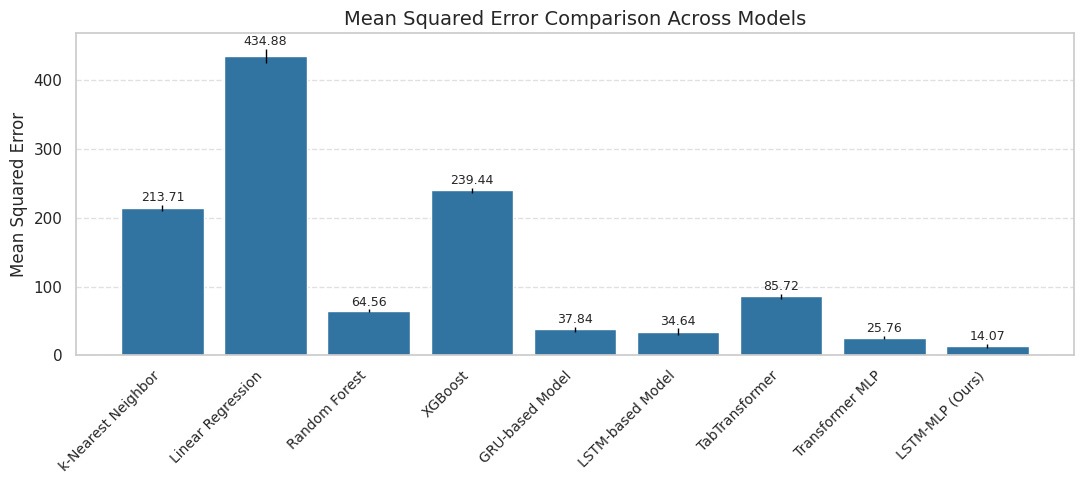

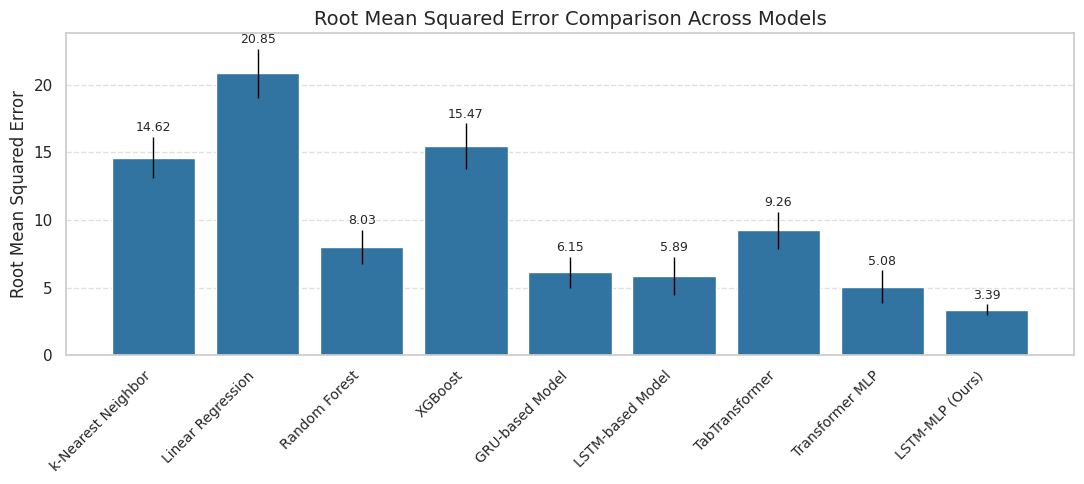

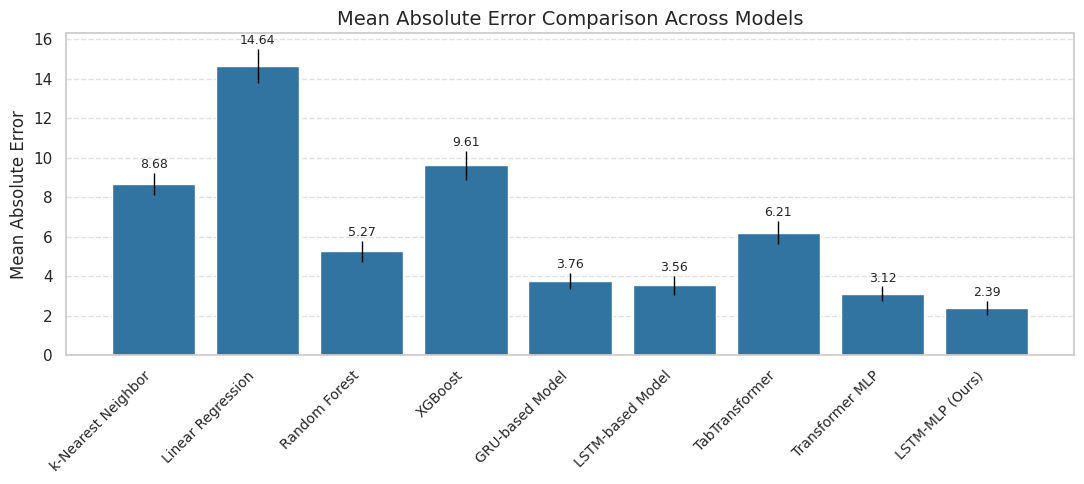

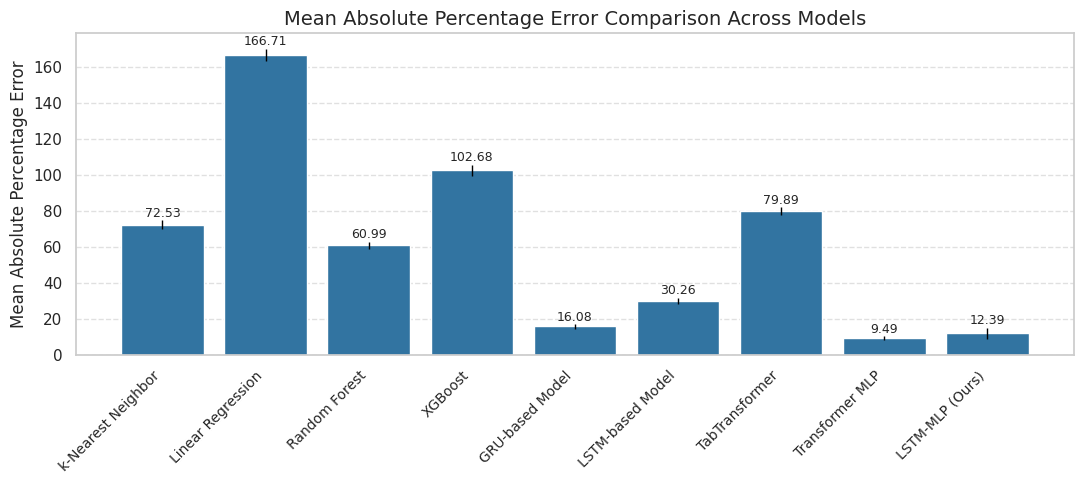

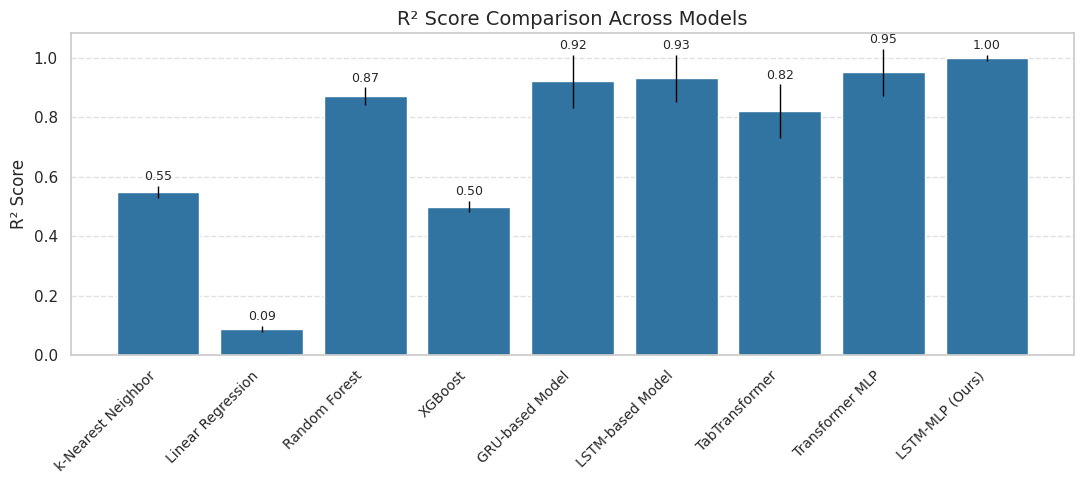

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

# Define data
data = {
    'Model': [
        'k-Nearest Neighbor', 'Linear Regression', 'Random Forest',
        'XGBoost', 'GRU-based Model', 'LSTM-based Model',
        'TabTransformer', 'Transformer MLP', 'LSTM-MLP (Ours)'
    ],
    'MSE': [213.71, 434.88, 64.56, 239.44, 37.84, 34.64, 85.72, 25.76, 14.07],
    'MSE_std': [4.65, 10.12, 2.11, 3.59, 3.23, 4.68, 3.74, 2.47, 2.9],
    'RMSE': [14.62, 20.85, 8.03, 15.47, 6.15, 5.89, 9.26, 5.08, 3.39],
    'RMSE_std': [1.54, 1.81, 1.24, 1.67, 1.14, 1.39, 1.37, 1.23, 0.41],
    'MAE': [8.68, 14.64, 5.27, 9.61, 3.76, 3.56, 6.21, 3.12, 2.39],
    'MAE_std': [0.56, 0.87, 0.54, 0.75, 0.41, 0.48, 0.59, 0.37, 0.37],
    'MAPE': [72.53, 166.71, 60.99, 102.68, 16.08, 30.26, 79.89, 9.49, 12.39],
    'MAPE_std': [2.35, 3.36, 2.17, 2.95, 1.25, 1.82, 2.26, 1.11, 3.04],
    'R2': [0.55, 0.09, 0.87, 0.50, 0.92, 0.93, 0.82, 0.95, 1.00],
    'R2_std': [0.02, 0.01, 0.03, 0.02, 0.09, 0.08, 0.09, 0.08, 0.01]
}

df = pd.DataFrame(data)

# Unified color
bar_color = "#1f77b4"  # a strong, academic blue

# Plotting function
def plot_metric(metric, std_metric, ylabel):
    plt.figure(figsize=(11, 5))

    ax = sns.barplot(
        data=df,
        x='Model',
        y=metric,
        color=bar_color,
        errorbar=None
    )

    # Manual error bars (vertical only, no caps)
    x_coords = [bar.get_x() + bar.get_width() / 2 for bar in ax.patches]
    ax.errorbar(
        x=x_coords,
        y=df[metric],
        yerr=df[std_metric],
        fmt='none',
        c='black',
        capsize=0,
        linewidth=1
    )

    # Add number labels above bars, avoid overlapping
    for x, y, err in zip(x_coords, df[metric], df[std_metric]):
        ax.text(
            x,
            y + err + max(df[std_metric]) * 0.1,  # push above error bar
            f"{y:.2f}",
            ha='center',
            va='bottom',
            fontsize=9
        )

    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel('')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.title(f'{ylabel} Comparison Across Models', fontsize=14)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Optional: Save figure
    # plt.savefig(f"{metric}_comparison.png", dpi=300)

    plt.show()

# Generate all plots
plot_metric('MSE', 'MSE_std', 'Mean Squared Error')
plot_metric('RMSE', 'RMSE_std', 'Root Mean Squared Error')
plot_metric('MAE', 'MAE_std', 'Mean Absolute Error')
plot_metric('MAPE', 'MAPE_std', 'Mean Absolute Percentage Error')
plot_metric('R2', 'R2_std', 'R² Score')


## comparison with proposed method among models

In [ ]:
import pandas as pd

data = {
    'Model': [
        'MLP-based model', 'GRU-based model', 'LSTM-based model',
        'LSTM-GRU model', 'GRU-LSTM model', 'GRU-MLP model',
        'Transformer Based [1]', 'LSTM-MLP (Ours)'
    ],
    'MSE': [24314.76, 721.9958, 78.76, 336.48, 234.38, 3711.27, 25.76, 14.07],
    'MSE_std': [1831.35, 121.98, 18.60, 60.09, 68.24, 542.04, 4.65, 2.9],
    'RMSE': [154.34, 25.04, 7.94, 17.02, 13.24, 58.23, 5.08, 3.39],
    'RMSE_std': [5.73, 2.51, 1.01, 1.76, 1.98, 4.61, 1.23, 0.41],
    'MAE': [101.34, 18.55, 6.90, 11.49, 8.18, 41.75, 3.12, 2.39],
    'MAE_std': [4.10, 2.12, 0.98, 1.29, 1.26, 4.22, 0.37, 0.37],
    'MAPE': [444.16, 13.95, 12.04, 18.91, 34.09, 60.50, 9.49, 12.39],
    'MAPE_std': [41.14, 0.91, 1.10, 2.51, 4.51, 10.62, 1.11, 3.04],
    'R2': [0.9885, 0.9997, 1.0, 0.9998, 0.99, 0.99, 0.95, 1.00],
    'R2_std': [0.000804, 0.000057, 0.000008, 0.000029, 0.000031, 0.000262, 0.08, 0.000001]
}

df2 = pd.DataFrame(data)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_horizontal(metric, std_metric, ylabel):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data=df2,
        y='Model',
        x=metric,
        color='#4a90e2'
    )

    y_coords = [bar.get_y() + bar.get_height() / 2 for bar in ax.patches]
    ax.errorbar(
        x=df2[metric],
        y=y_coords,
        xerr=df2[std_metric],
        fmt='none',
        c='black',
        capsize=0,
        linewidth=1
    )

    for y, val, err in zip(y_coords, df2[metric], df2[std_metric]):
        ax.text(val + err + max(df2[std_metric]) * 0.1, y, f"{val:.2f}", va='center', fontsize=9)

    ax.set_xlabel(ylabel, fontsize=12)
    ax.set_ylabel('')
    plt.title(f'{ylabel} Comparison', fontsize=14)
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

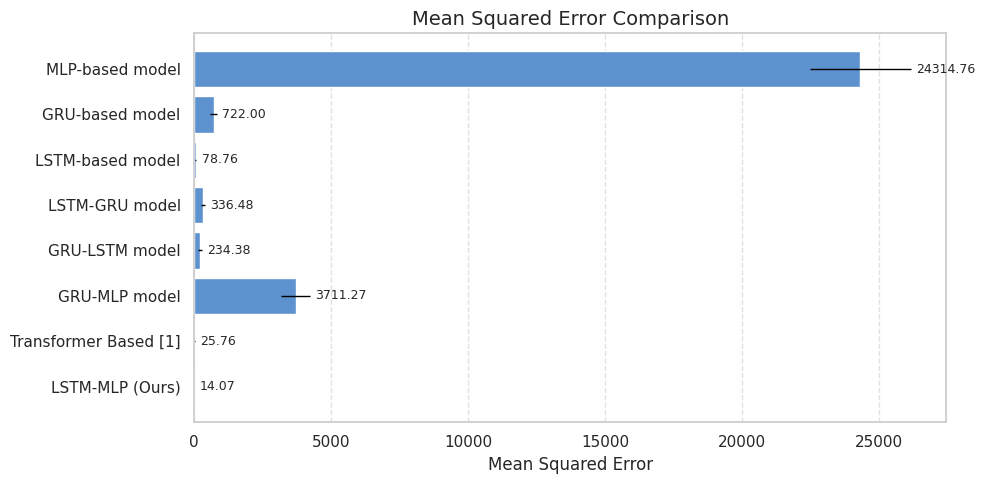

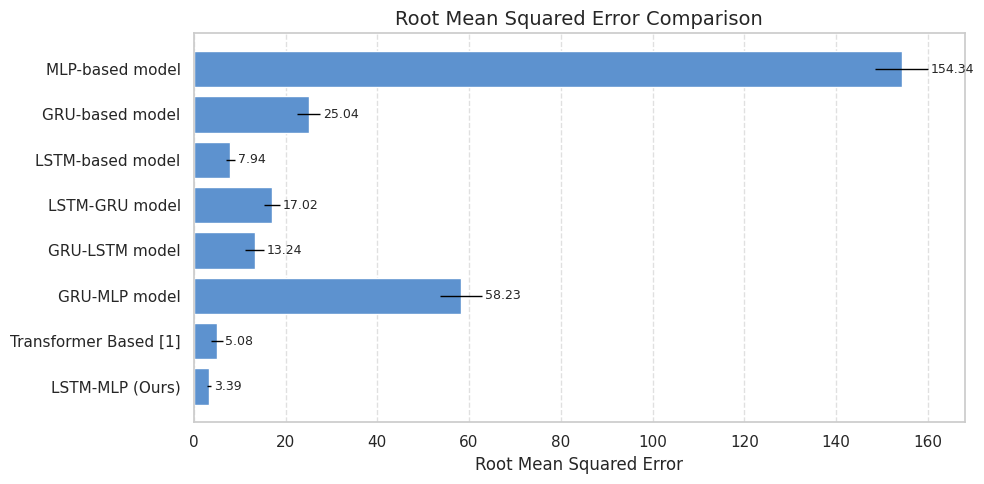

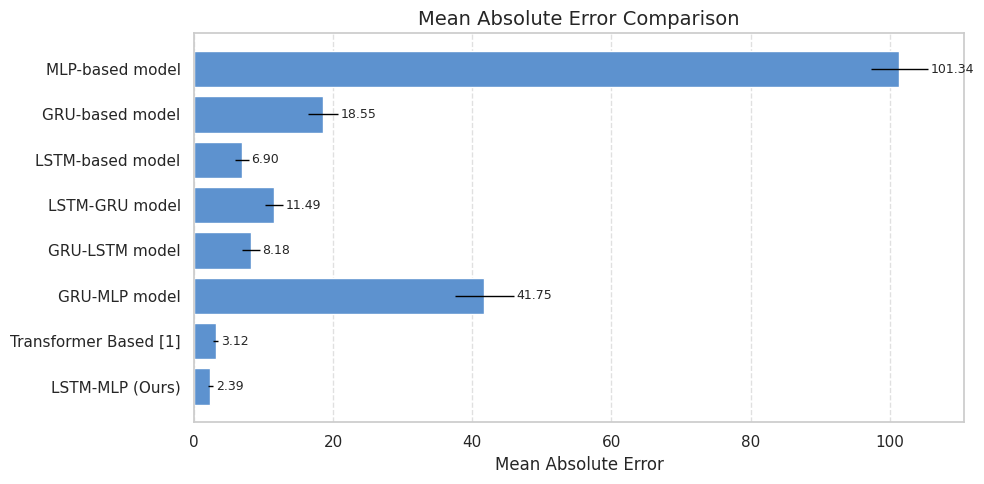

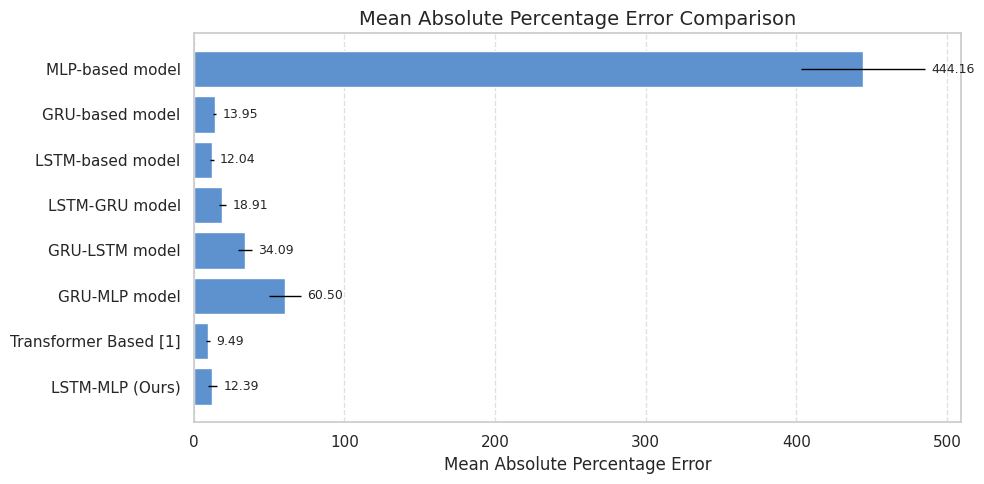

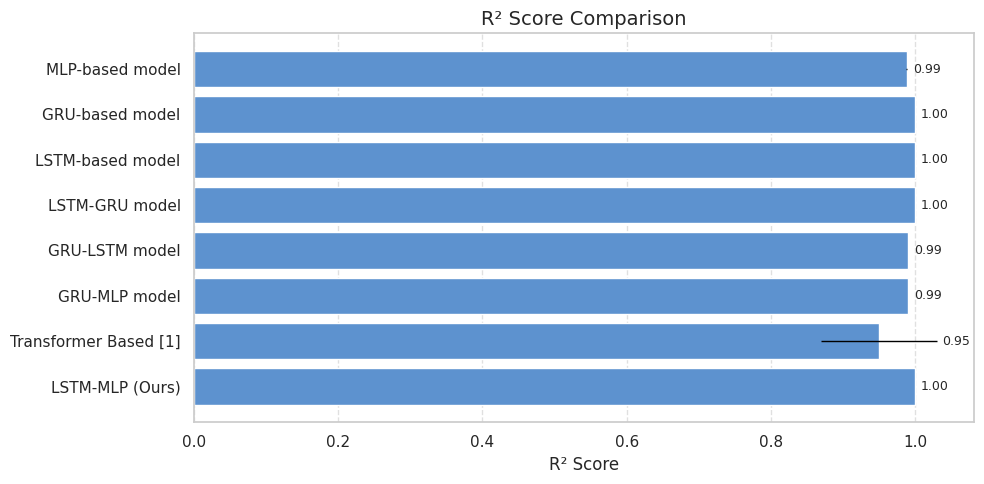

In [ ]:
plot_horizontal('MSE', 'MSE_std', 'Mean Squared Error')
plot_horizontal('RMSE', 'RMSE_std', 'Root Mean Squared Error')
plot_horizontal('MAE', 'MAE_std', 'Mean Absolute Error')
plot_horizontal('MAPE', 'MAPE_std', 'Mean Absolute Percentage Error')
plot_horizontal('R2', 'R2_std', 'R² Score')

# Bab 2 Figures

## KNN

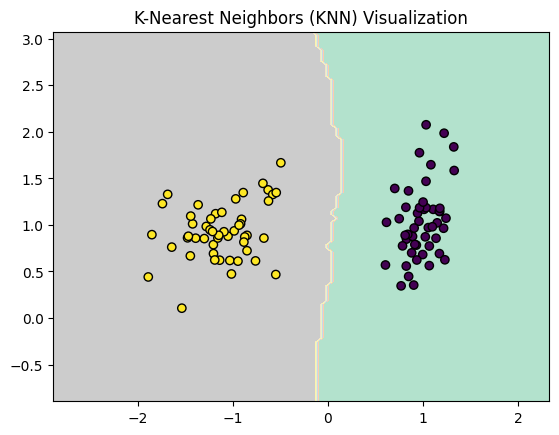

In [ ]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

# Dummy data
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=1, n_samples=100, random_state=1)

# Model
model = KNeighborsClassifier(n_neighbors=5).fit(X, y)

# Plot
disp = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", cmap="Pastel2")
disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
plt.title("K-Nearest Neighbors (KNN) Visualization")
plt.show()

## Linear Regression

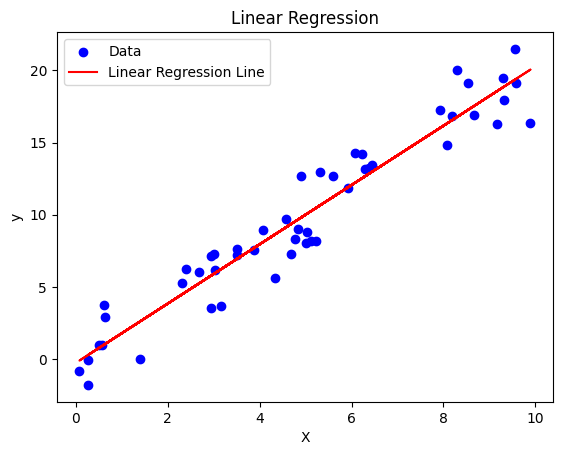

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Dummy data
X = np.random.rand(50, 1) * 10
y = 2 * X.squeeze() + np.random.randn(50) * 2

# Model
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Plot
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, y_pred, color='red', label='Linear Regression Line')
plt.title("Linear Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

## Random Forest

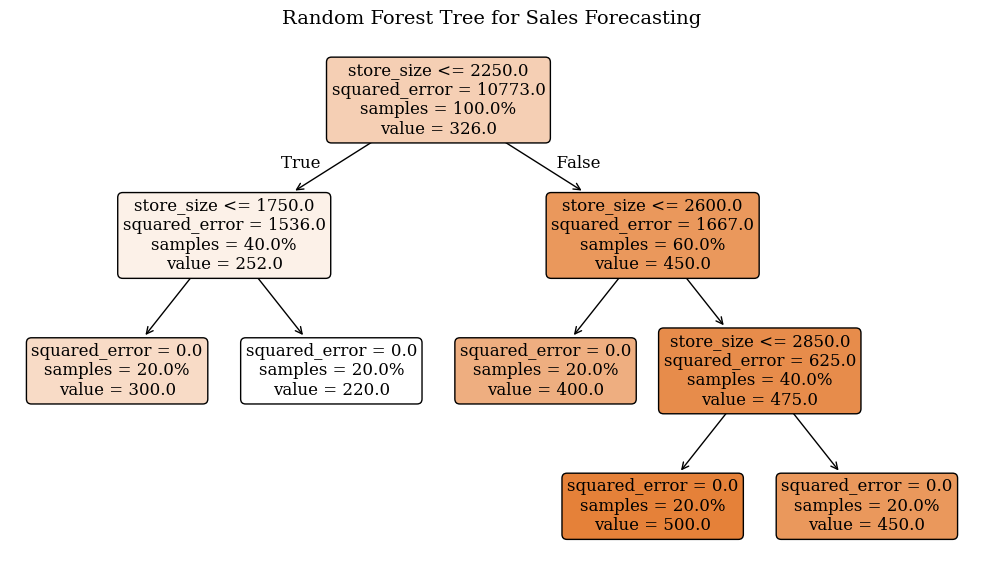

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import pandas as pd

# Contoh dataset penjualan
data = {
    "store_size": [1000, 1500, 2000, 2500, 3000, 1800, 2200, 2700],
    "promo": [0, 1, 0, 1, 1, 0, 1, 1],
    "holiday": [0, 0, 1, 0, 1, 0, 0, 1],
    "weekly_sales": [200, 300, 220, 400, 450, 280, 370, 500]
}
df = pd.DataFrame(data)

X = df.drop("weekly_sales", axis=1)
y = df["weekly_sales"]

model = RandomForestRegressor(n_estimators=1, max_depth=3, random_state=42)
model.fit(X, y)

# Font setup (mirip Times New Roman)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
plt.rcParams['font.size'] = 12

# Gambar pohon
fig, ax = plt.subplots(figsize=(10, 6))  # Ukuran pas
plot_tree(model.estimators_[0],
          feature_names=X.columns,
          filled=True,
          rounded=True,
          precision=0,
          proportion=True,
          node_ids=False,
          fontsize=12,
          ax=ax)

plt.title("Random Forest Tree for Sales Forecasting", fontsize=14)
plt.tight_layout()
plt.savefig("rf_sales_tree_clean.png", dpi=300)
plt.show()

## XGBoost

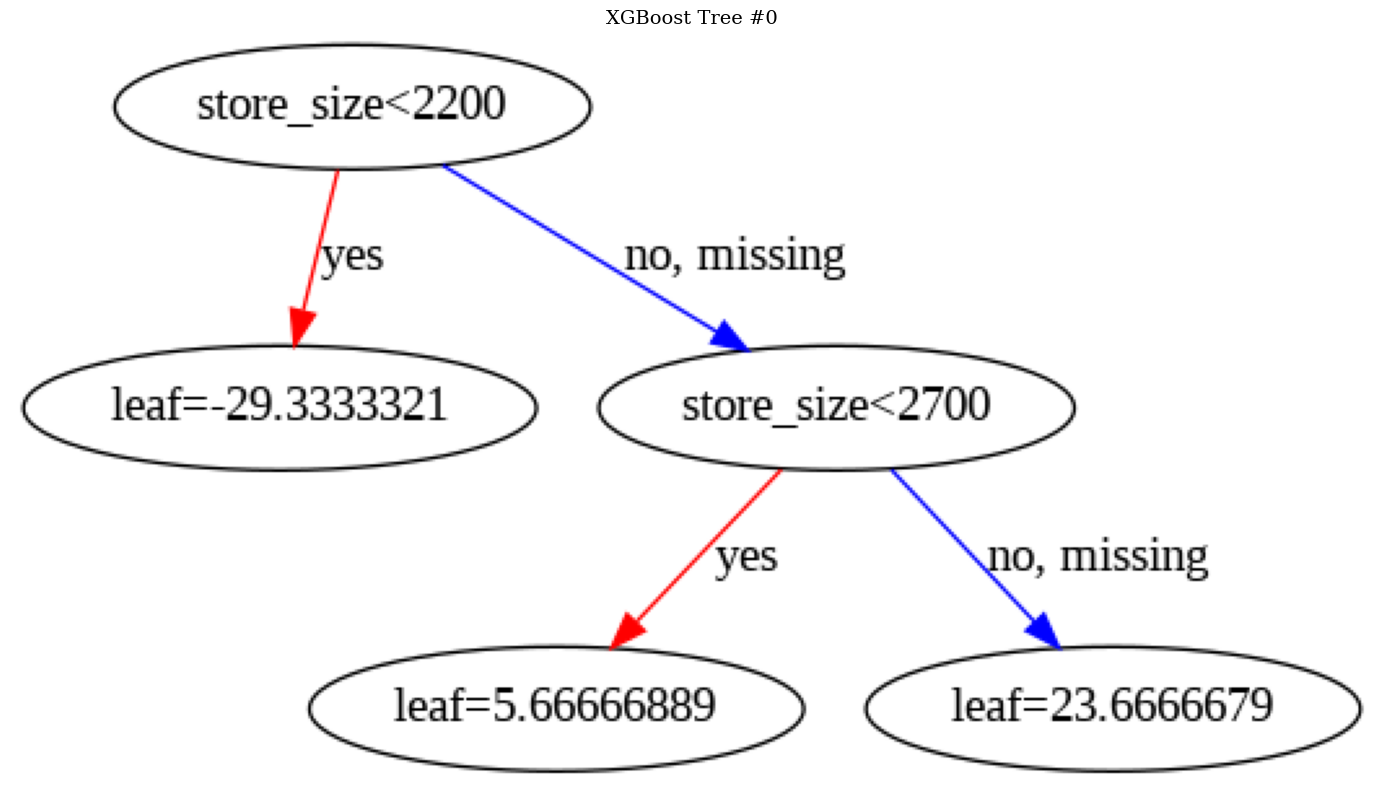

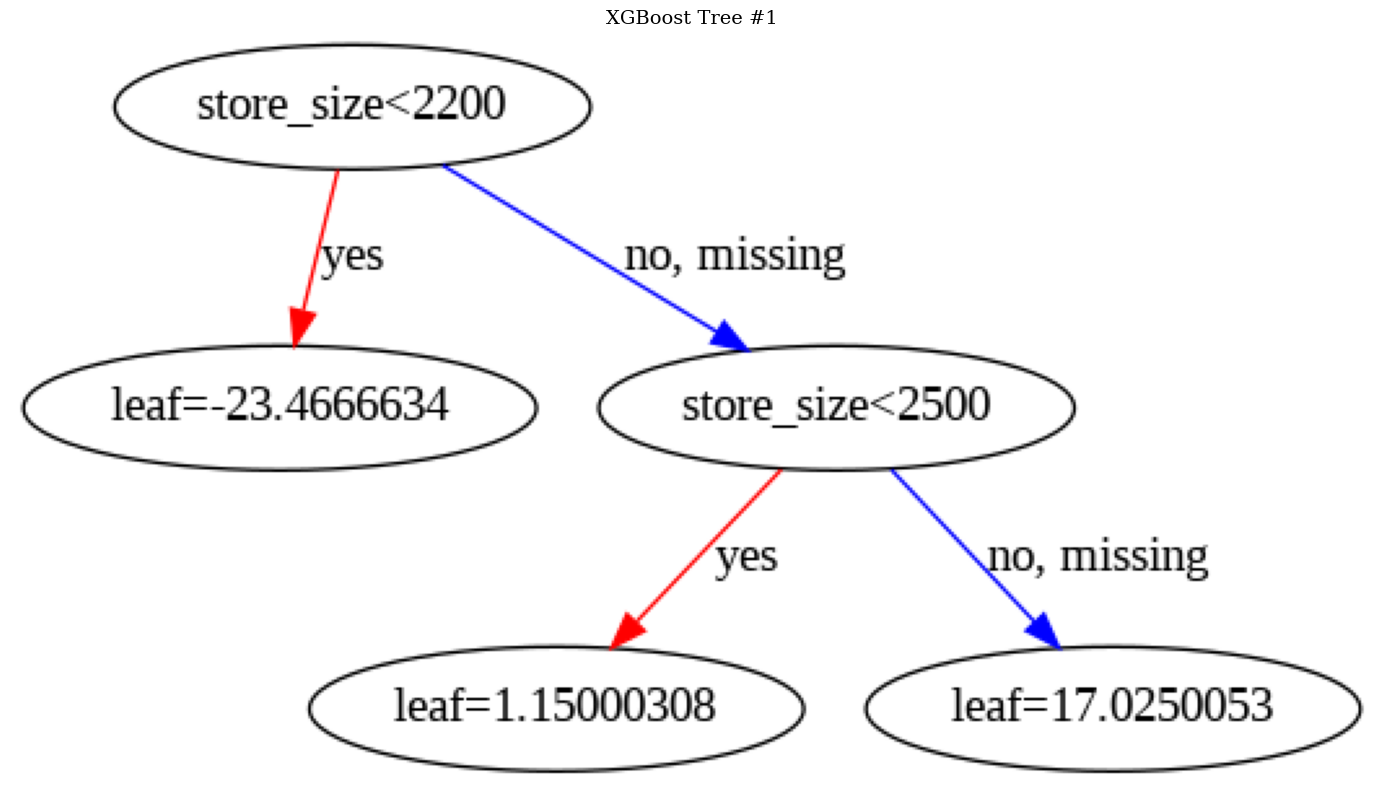

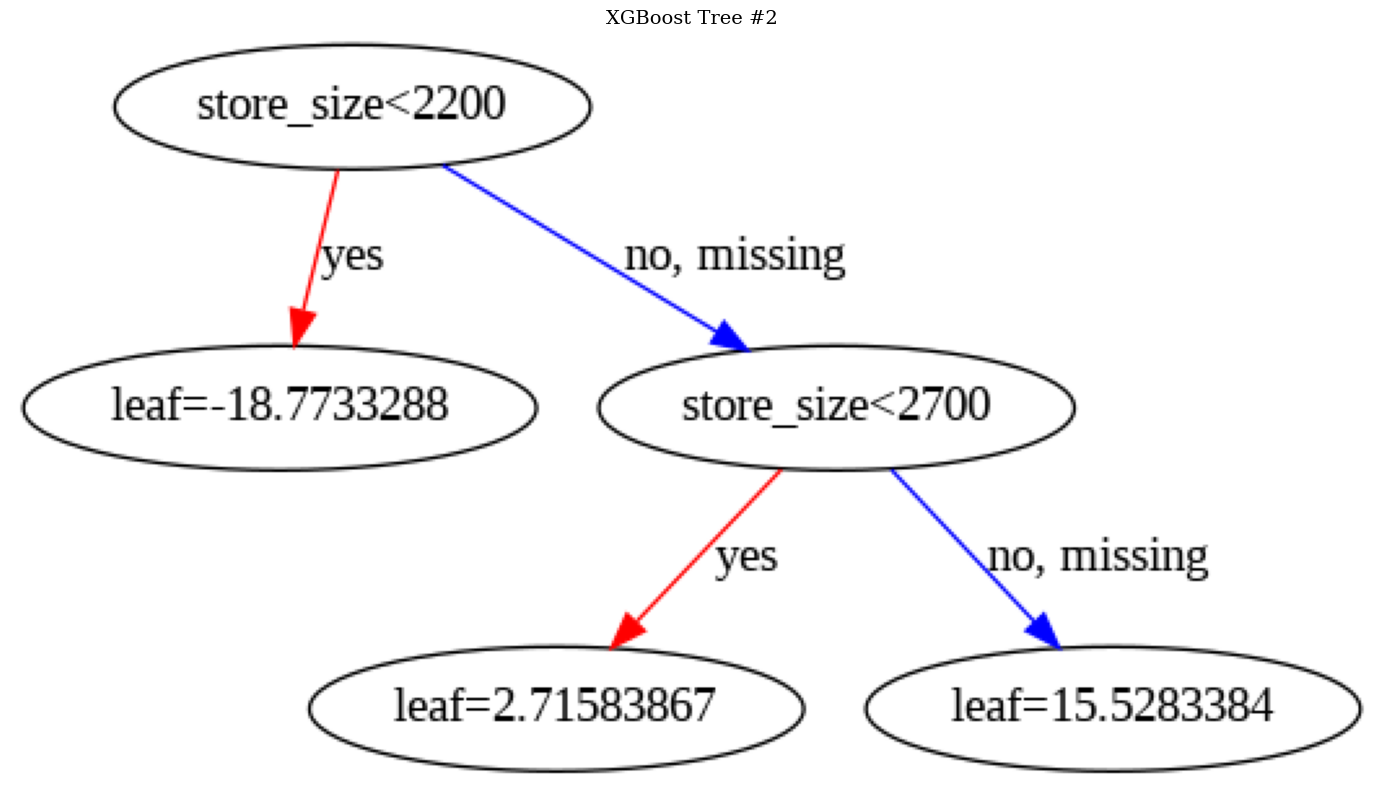

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Sample dataset
data = {
    "store_size": [1000, 1500, 2000, 2500, 3000, 1800, 2200, 2700],
    "promo": [0, 1, 0, 1, 1, 0, 1, 1],
    "holiday": [0, 0, 1, 0, 1, 0, 0, 1],
    "weekly_sales": [200, 300, 220, 400, 450, 280, 370, 500]
}
df = pd.DataFrame(data)

X = df.drop("weekly_sales", axis=1)
y = df["weekly_sales"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Font setup
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
plt.rcParams['font.size'] = 12

# Train model with multiple estimators to reflect boosting
model = xgb.XGBRegressor(n_estimators=10, max_depth=2, learning_rate=0.3,
                         objective="reg:squarederror", random_state=42)
model.fit(X_train, y_train)

# Get total number of boosted trees (equal to n_estimators)
num_trees = model.get_booster().num_boosted_rounds()

# Plot the first 3 trees to see the boosting process
for i in range(min(3, num_trees)):  # Adjust number of trees as needed
    fig, ax = plt.subplots(figsize=(14, 10))
    xgb.plot_tree(model, num_trees=i, ax=ax, rankdir='TB')
    plt.title(f"XGBoost Tree #{i}", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"xgboost_tree_{i}.png", dpi=300)
    plt.show()

## GRU

# Bab 4 Figures (Result Manual Visualisation)

## Error comparison among model

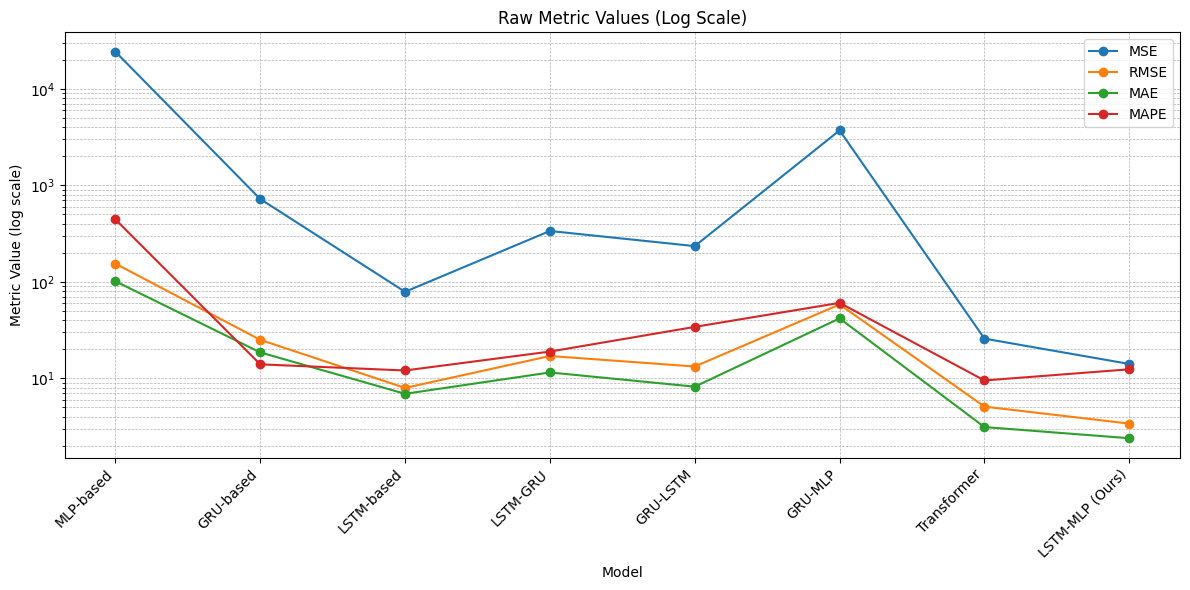

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Data
data = {
    "Model": [
        "MLP-based", "GRU-based", "LSTM-based", "LSTM-GRU", "GRU-LSTM",
        "GRU-MLP", "Transformer", "LSTM-MLP (Ours)"
    ],
    "MSE": [24314.76, 721.9958, 78.76, 336.48, 234.38, 3711.27, 25.76, 14.07],
    "RMSE": [154.34, 25.04, 7.94, 17.02, 13.24, 58.23, 5.08, 3.39],
    "MAE": [101.34, 18.55, 6.90, 11.49, 8.18, 41.75, 3.12, 2.39],
    "MAPE": [444.16, 13.95, 12.04, 18.91, 34.09, 60.50, 9.49, 12.39]
    # "R2": [0.9885, 0.9997, 1.0000, 0.9998, 0.99, 0.99, 0.95, 1.00]
}

df = pd.DataFrame(data)

# Normalize all metric columns (except "Model")
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df.iloc[:, 1:])
normalized_df = pd.DataFrame(normalized_values, columns=df.columns[1:])
normalized_df["Model"] = df["Model"]

# Plot without normalization, use log scale
plt.figure(figsize=(12, 6))
for metric in df.columns[1:]:
    plt.plot(df["Model"], df[metric], marker='o', label=metric)

plt.yscale('log')
plt.title("Raw Metric Values (Log Scale)")
plt.xlabel("Model")
plt.ylabel("Metric Value (log scale)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## R2 score of phase 2

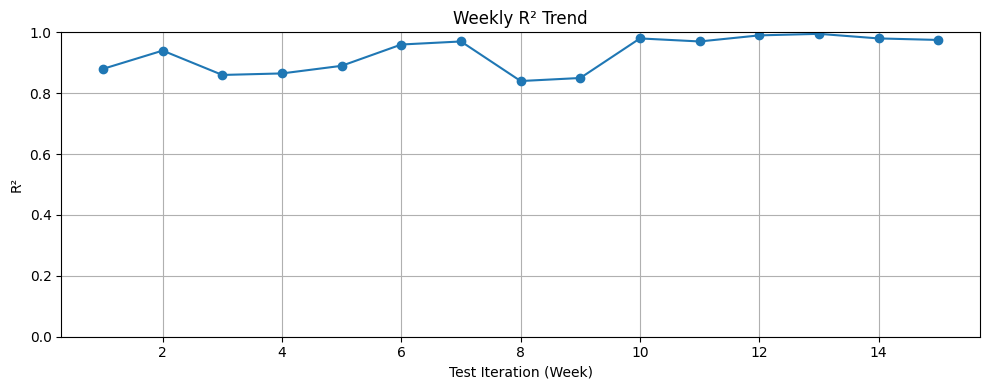

In [ ]:
import matplotlib.pyplot as plt

# Contoh data dummy
weeks = list(range(1, 16))
r2_scores = [0.88, 0.94, 0.86, 0.865, 0.89, 0.96, 0.97, 0.84, 0.85,
             0.98, 0.97, 0.99, 0.995, 0.98, 0.975]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(weeks, r2_scores, marker='o')

plt.title("Weekly R² Trend")
plt.xlabel("Test Iteration (Week)")
plt.ylabel("R²")

# Set y-axis limit manually (from 0 to 1)
plt.ylim(0, 1)

# Turn off scientific notation
plt.ticklabel_format(style='plain', axis='y')

plt.grid(True)
plt.tight_layout()
plt.show()